* Compare fresh water transport across different river flow conditions, especially looking at effects of Coriolis force and winds.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139},
            '6':{'jst':55,  'ist': 0,'jen':56,'ien':25},
            '7':{'jst':25,'ist':0, 'jen':26,'ien':25}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.8, 49.7)

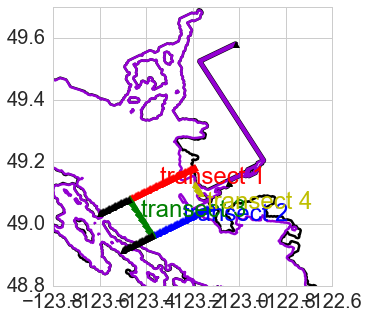

In [5]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[55,0:25],Y[55,0:25],'k^')
ax.plot(X[25,0:25],Y[25,0:25],'k^')
ax.plot(X[120:121,155],Y[120:121,155],'k^')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.8,-122.6])
ax.set_ylim([48.8,49.7])

In [6]:
## load salinity into a dict
pathsoct = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
pathsmay = ['May2015OnlyRiver','May2015notides','May2015nowind','May2015nof','May2015combineall']
pathsjan = ['Jan2016OnlyRiver','Jan2016notides','Jan2016nowind','Jan2016nof','Jan2016combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternTs = ['oct2014*_T.nc','may2015*_T.nc','jan2016*_T.nc']
file_patternUs = ['oct2014*_U.nc','may2015*_U.nc','jan2016*_U.nc']
file_patternVs = ['oct2014*_V.nc','may2015*_V.nc','jan2016*_V.nc']
U = {}; V={}; S={};ssh = {}
paths = [pathsoct,pathsmay,pathsjan]
for paa,Tfile, Ufile,Vfile in zip(paths,file_patternTs,file_patternUs,file_patternVs):
    for pa in paa:
        pathT = glob(os.path.join(base,pa, Tfile))
        pathU = glob(os.path.join(base,pa, Ufile))
        pathV = glob(os.path.join(base,pa, Vfile))
        fU = nc.Dataset(pathU[0],'r');
        U[pa] = fU.variables['vozocrtx']
        fV = nc.Dataset(pathV[0],'r');
        V[pa] = fV.variables['vomecrty']
        fT = nc.Dataset(pathT[0],'r');
        S[pa] = fT.variables['vosaline']
        lon = fT.variables['nav_lon'] 
        lat = fT.variables['nav_lat']
        ssh[pa] = fT.variables['sossheig']
        time_counter = fT.variables['time_counter']
        depT = fT.variables['deptht']

In [7]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """to calculate the total transport (False)or fresh water transport (True) in the entire water column 
    with focus on a continous time period rather than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst']-1,transects[tran]['jen'])
    iinds = np.arange(transects[tran]['ist']-1,transects[tran]['ien'])
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depT.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st[pa],t_en[pa]+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depT,tran,t_st,t_en,\
                                                 paths,fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [8]:
def transport_time_general(S,U,V,ssh,lon,lat,depT,tran,t_st,t_en,paths,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j+1,1])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst']+1,transects[tran]['ist']+1]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depT.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st[pa],t_en[pa]+1):
                for z in np.arange(depT.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,1,i+1])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst']+1,i+transects[tran]['ist']+1]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st[pa]:t_en[pa]+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st[pa]:t_en[pa]+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [9]:
def plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = 'fresh'):
    """This function is the same with plot_series_transport, except 
    that this is not integral over several days, but only for daily case, over selected depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 paths,fresh_flag = fresh_flag)
    inte_trans = {}; 
    for ty in paths:
        inte_trans[ty] = np.zeros((ten[ty]-tst[ty]+1)/24)
        for i in np.arange(tst[ty],ten[ty]+1,24): ## intergral individual daily
            inte_trans[ty][i/24-tst[ty]/24] = np.nansum(trans[ty][i:i+24,depT[0]:depT[dep]+1])*3600
    fig, axs = plt.subplots(2,1,figsize = (20,9))
    ax = axs[0] ## ssh
    for ty in paths:
        ax.plot(ssh[ty][tst[ty]:ten[ty]+1,86,89],label = ty)
    ax.set_ylabel('ssh at PA [m]')
    ax.set_xlabel('hour')
    ax = axs[1] ## total volumn flux,salt flux and freshwater flux for selected run case
    for ty in paths:
        ax.plot(inte_trans[ty],'o',label = ty,markersize = 10)
        if fresh_flag == 'fresh':
            ax.set_ylabel('fresh water flux $m^3$')
        else:
            ax.set_ylabel('flux $m^3$')
        ax.set_xlim([-1,(ten[ty]+1-tst[ty])/24])
    ax.legend(loc = 'best')
    ax.set_xlabel('Day')
    return inte_trans

In [10]:
def freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,tran,tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag):
    """Plot freshwater time series in a month for different river flows"""
    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(3, 2,width_ratios=[0.4,1], height_ratios=[1,1,1])  
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])
    ax4 = fig.add_subplot(gs[2,1])
    ## plot transect
    viz_tools.plot_coastline(ax1, grid6, coords = 'map')
    
    ax1.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],\
             Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],'r^')        
    ax1.set_xlim([-123.6,-122.6])
    ax1.set_ylim([48.9,49.7])
    trans = {};trans_surf = {};trans_to = {}
    ## plot oct freshwater
    for path, month, tst,ten,ax in zip([paths_oct,paths_may,paths_jan],['oct','may','jan'],\
                                       [tst_oct,tst_may,tst_jan],[ten_oct,ten_may,ten_jan],[ax2,ax3,ax4]):
        trans[month],trans_surf[month],trans_to[month] = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 path,fresh_flag = fresh_flag)
        for pa in path:
            ax.plot(trans_to[month][pa],label = pa)
            ax.legend(loc = 'best') 
        #if tran == '1':
            #ax.set_ylim([-1.2e7, 2.5e6])
        #if tran =='2':
            #ax.set_ylim([-1.4e7,0])
        #if tran =='3':
            #ax.set_ylim([-8.5e5,1e6])
        #if tran =='4':
            #ax.set_ylim([-3e6,0])
    ax2.set_ylabel('Freshwater transport [$m^3$]')
    ax4.set_xlabel('Time [hr]')
    return trans_to

In [11]:
def freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,tran,tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag):
    """Plot freshwater time series in a month for different river flows"""
    fig = plt.figure(figsize=(18,14))
    gs = gridspec.GridSpec(3, 2,width_ratios=[0.4,1], height_ratios=[1,1,1])  
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,1])
    ax4 = fig.add_subplot(gs[2,1])
    ## plot transect
    viz_tools.plot_coastline(ax1, grid6, coords = 'map')
    
    ax1.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],\
             Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']:transects[tran]['ien']],'r^')        
    ax1.set_xlim([-123.6,-122.6])
    ax1.set_ylim([48.9,49.7])
    trans = {};trans_surf = {};trans_to = {}
    ## plot oct freshwater
    for path, month, tst,ten,ax in zip([paths_oct,paths_may,paths_jan],['oct','may','jan'],\
                                       [tst_oct,tst_may,tst_jan],[ten_oct,ten_may,ten_jan],[ax2,ax3,ax4]):
        trans[month],trans_surf[month],trans_to[month] = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                 path,fresh_flag = fresh_flag)
        for pa in path:
            ax.plot(np.cumsum(np.nansum(trans[month][pa][depT[0]:depT[10]], axis= 1)),label = pa)
            ax.legend(loc = 'best') 
                    
        #if tran == '1':
            #ax.set_ylim([-1.2e7, 2.5e6])
        #if tran =='2':
            #ax.set_ylim([-1.4e7,0])
        #if tran =='3':
            #ax.set_ylim([-8.5e5,1e6])
        #if tran =='4':
            #ax.set_ylim([-3e6,0])
    ax2.set_ylabel('Freshwater transport [$m^3$]')
    ax4.set_xlabel('Time [hr]')
    return trans_to

In [12]:
paths_oct = ['Oct2014nowind','Oct2014OnlyRiver','Oct2014nof','Oct2014combineall']
paths_may = ['May2015nowind','May2015OnlyRiver','May2015nof','May2015combineall']
paths_jan = ['Jan2016nowind','Jan2016OnlyRiver','Jan2016nof','Jan2016combineall'];
tst_oct = {'Oct2014nowind':0,'Oct2014OnlyRiver':0,'Oct2014nof':0,'Oct2014combineall':0}
ten_oct = {'Oct2014nowind':743,'Oct2014OnlyRiver':743,'Oct2014nof':743,'Oct2014combineall':743}
tst_may = {'May2015nowind':0,'May2015OnlyRiver':0,'May2015nof':0,'May2015combineall':0}
ten_may = {'May2015nowind':743,'May2015OnlyRiver':743,'May2015nof':743,'May2015combineall':743}
tst_jan = {'Jan2016nowind':0,'Jan2016OnlyRiver':0,'Jan2016nof':0,'Jan2016combineall':0}
ten_jan = {'Jan2016nowind':743,'Jan2016OnlyRiver':743,'Jan2016nof':743,'Jan2016combineall':743}

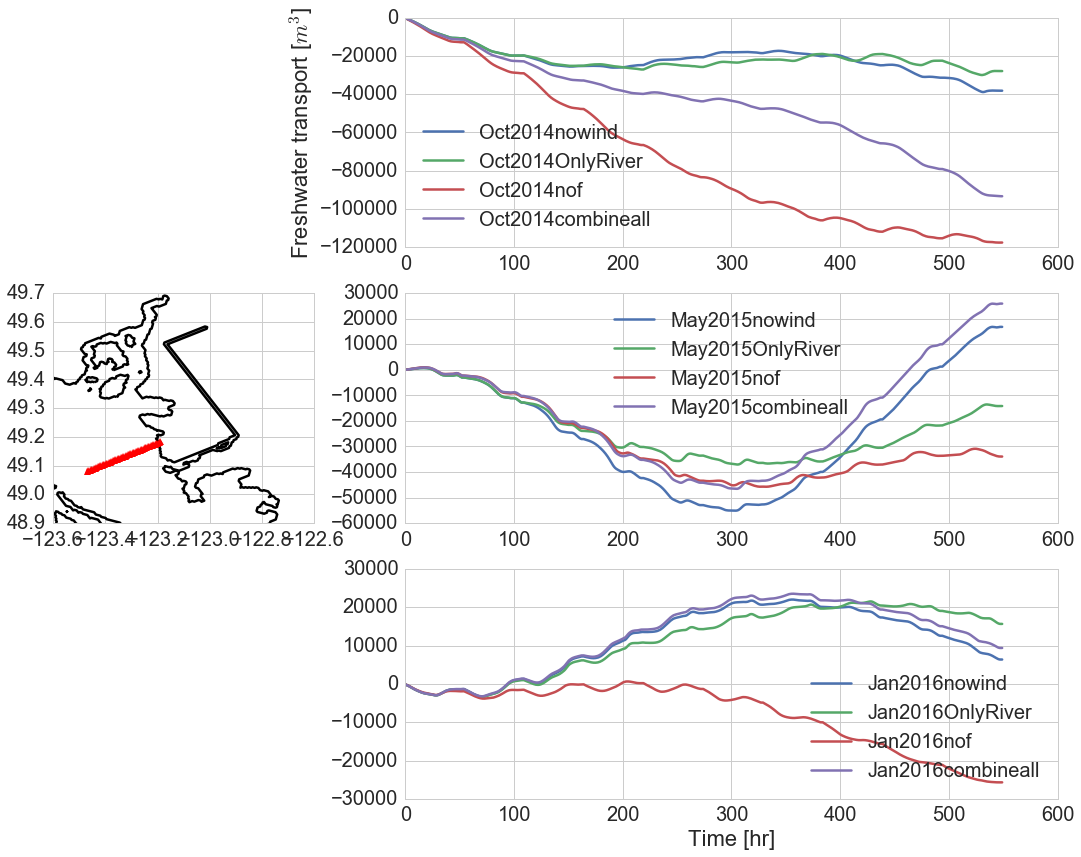

In [13]:
## upper box 10m 
trans_toUpper = freshwater_timeseries_upper(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

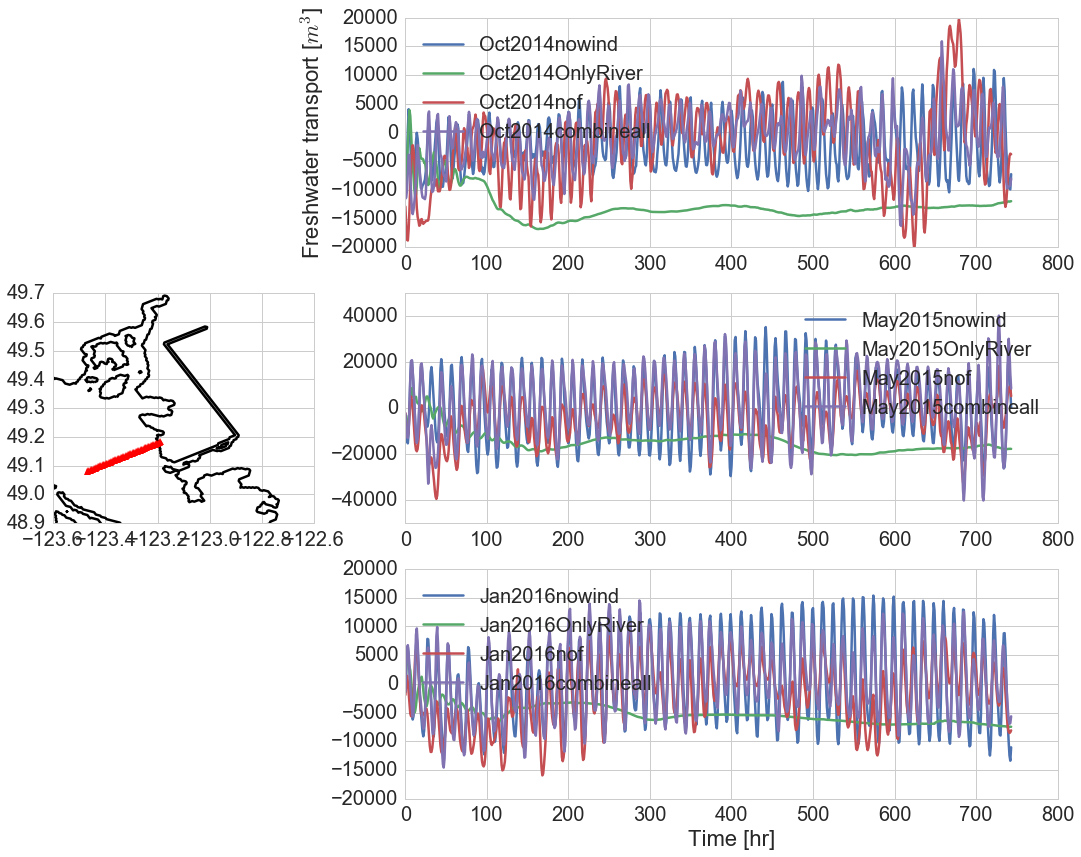

In [14]:
## upper box all depths if not cumsum
trans_toUp = freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

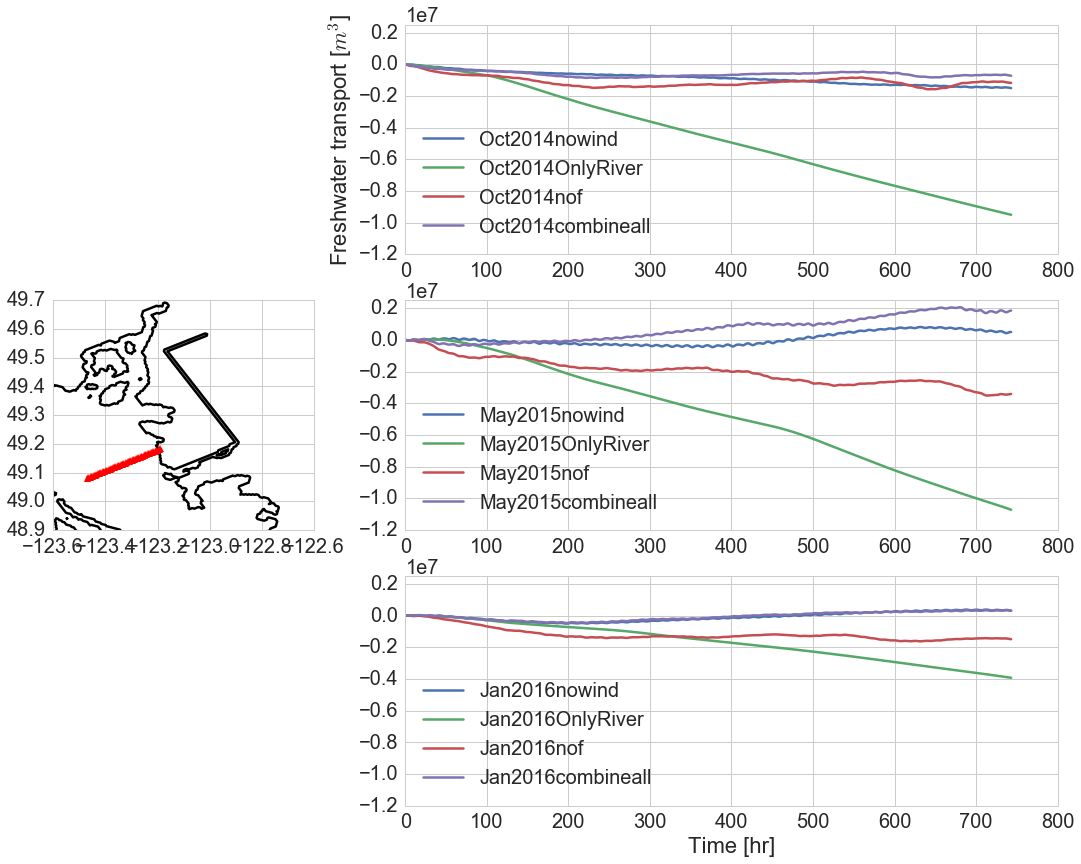

In [14]:
## upper box
trans_toUp = freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

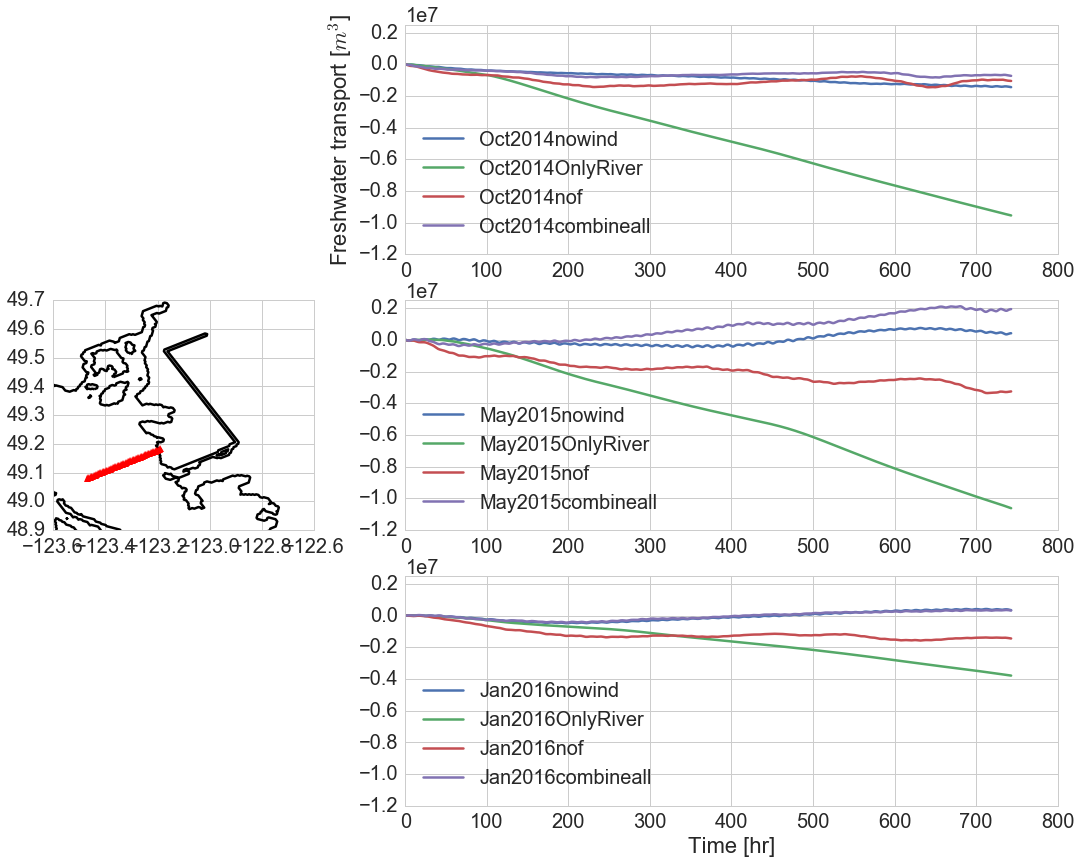

In [13]:
## upper box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'1',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

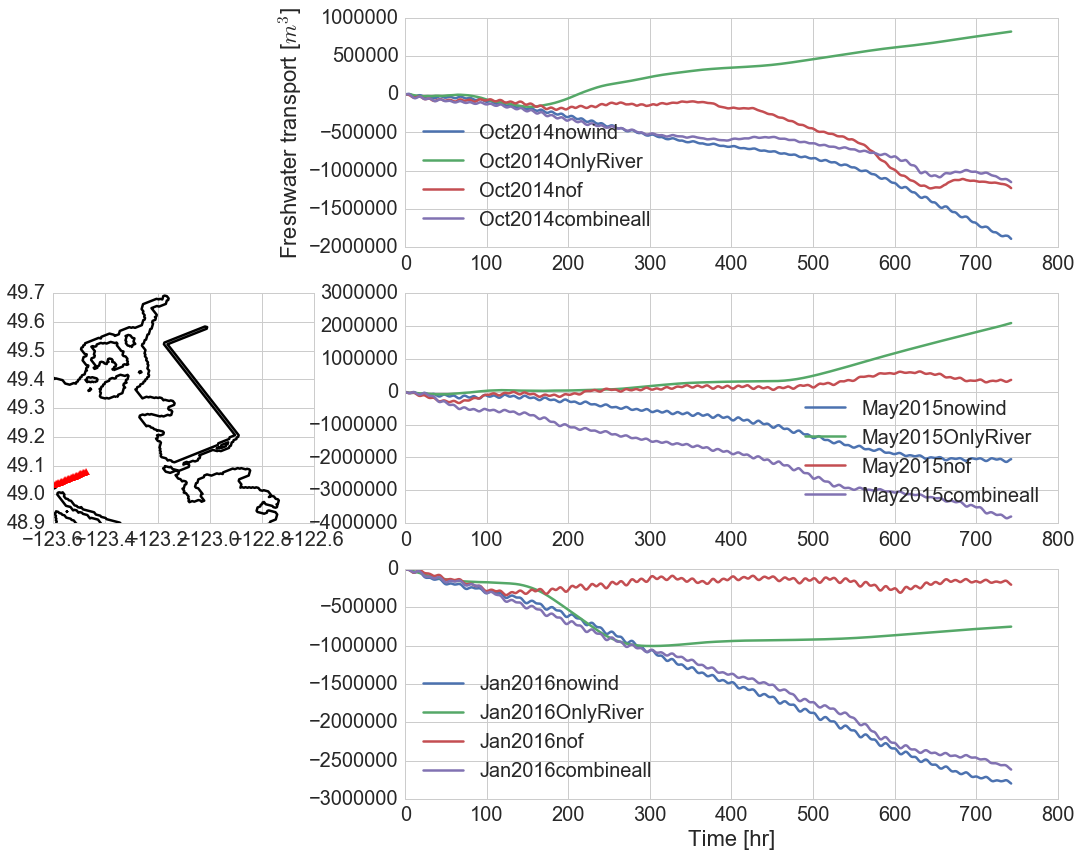

In [17]:
## upper left box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'6',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

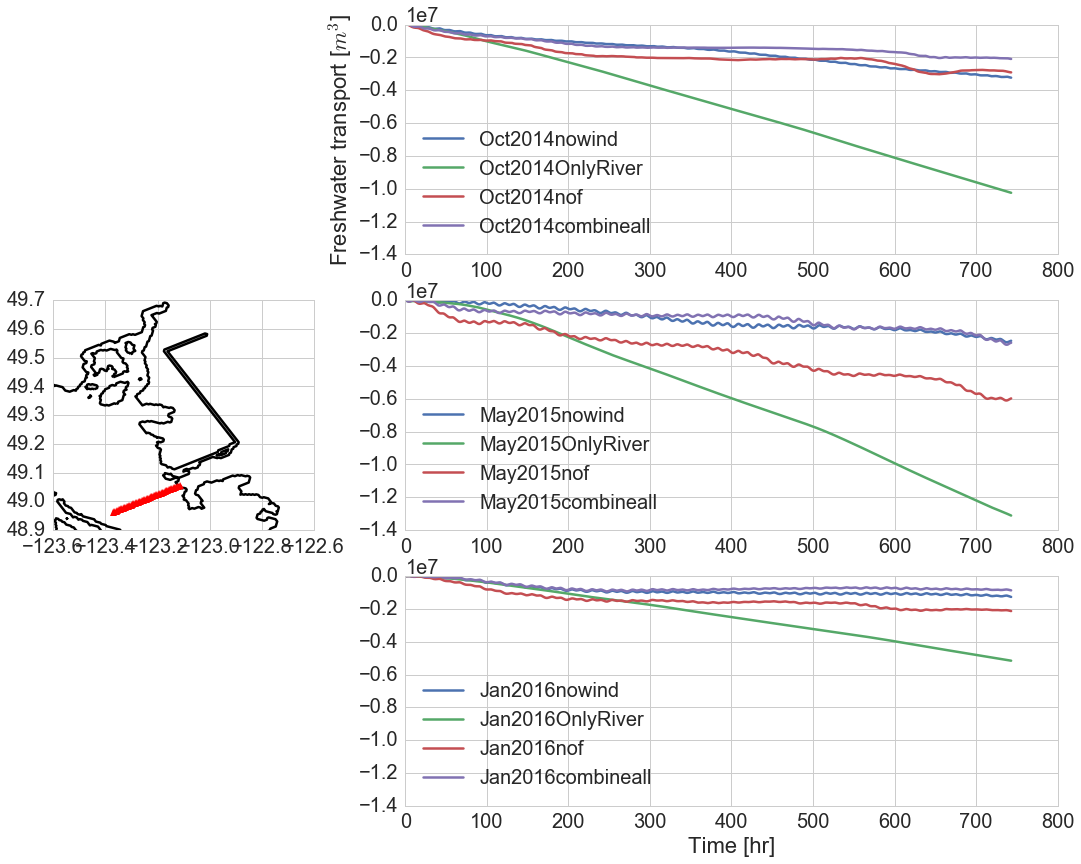

In [14]:
## lower box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'2',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

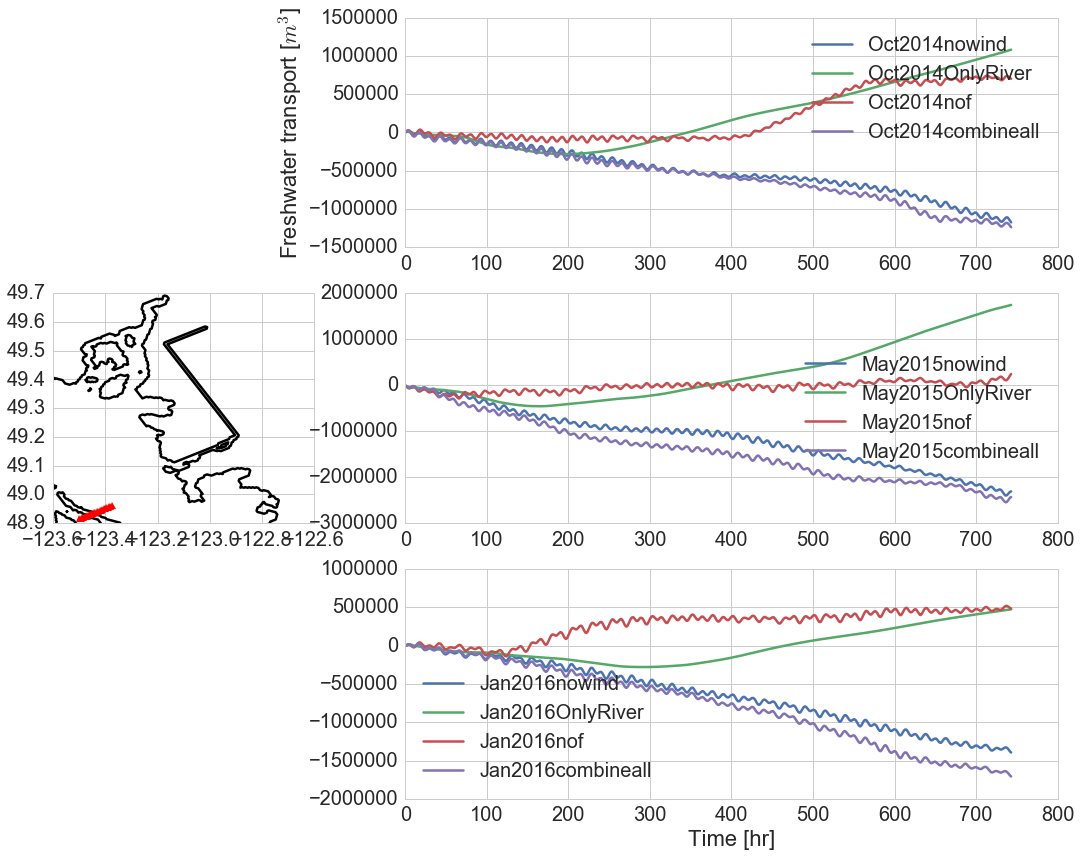

In [23]:
## lower left box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'7',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

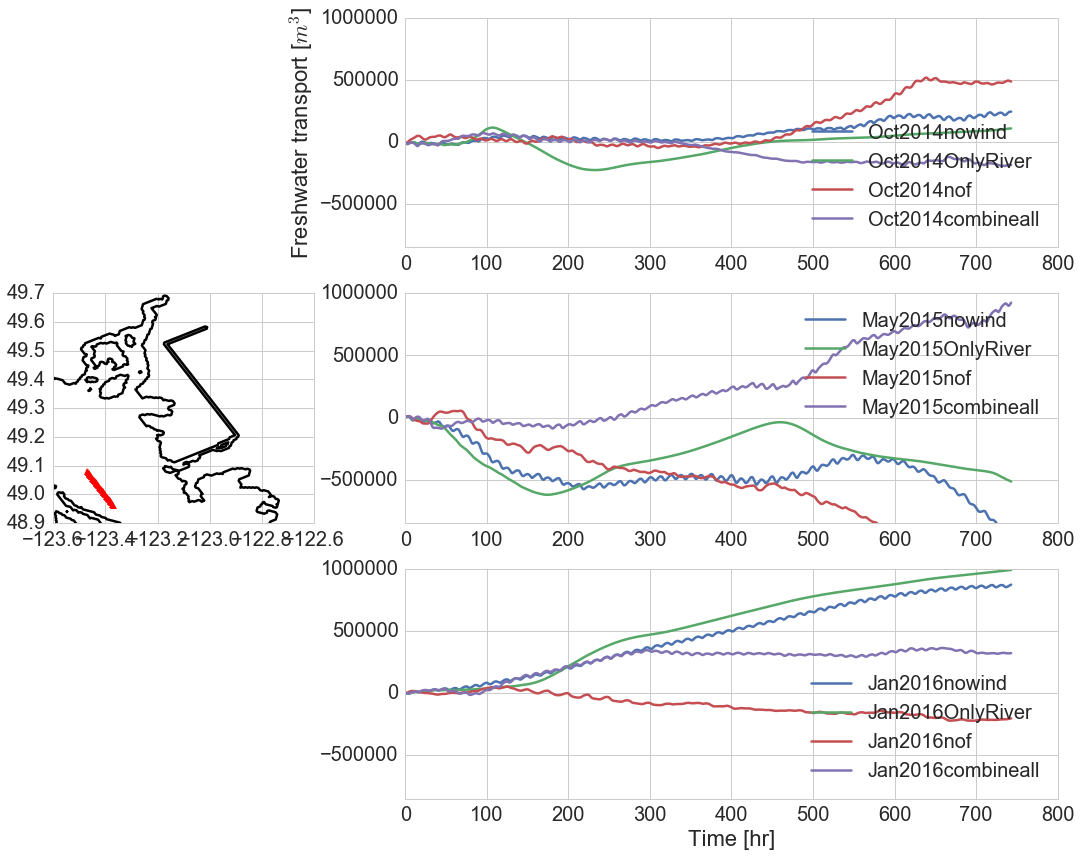

In [16]:
## left box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'3',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

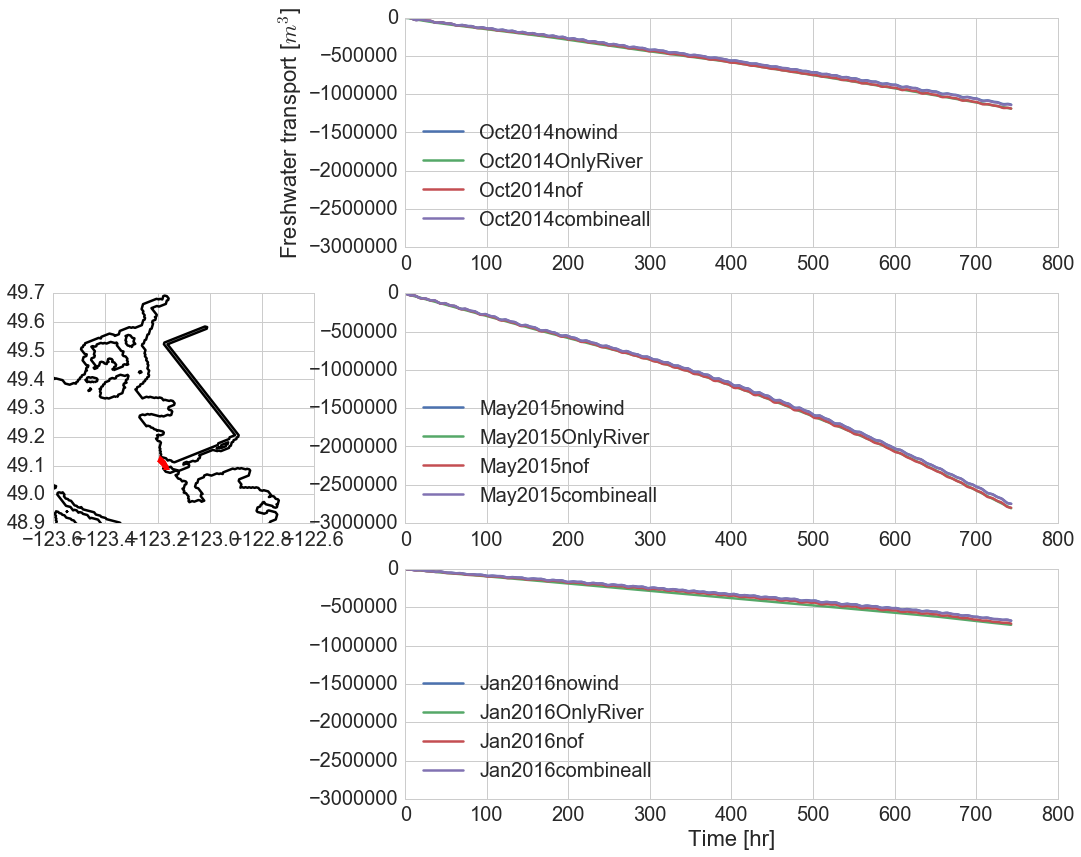

In [13]:
## right box
freshwater_timeseries(S,U,V,ssh,lon,lat,depT,paths_oct,paths_may,paths_jan,'4',tst_oct,ten_oct,\
                          tst_may,ten_may,tst_jan,ten_jan,fresh_flag='fresh')

1088.6089737542113

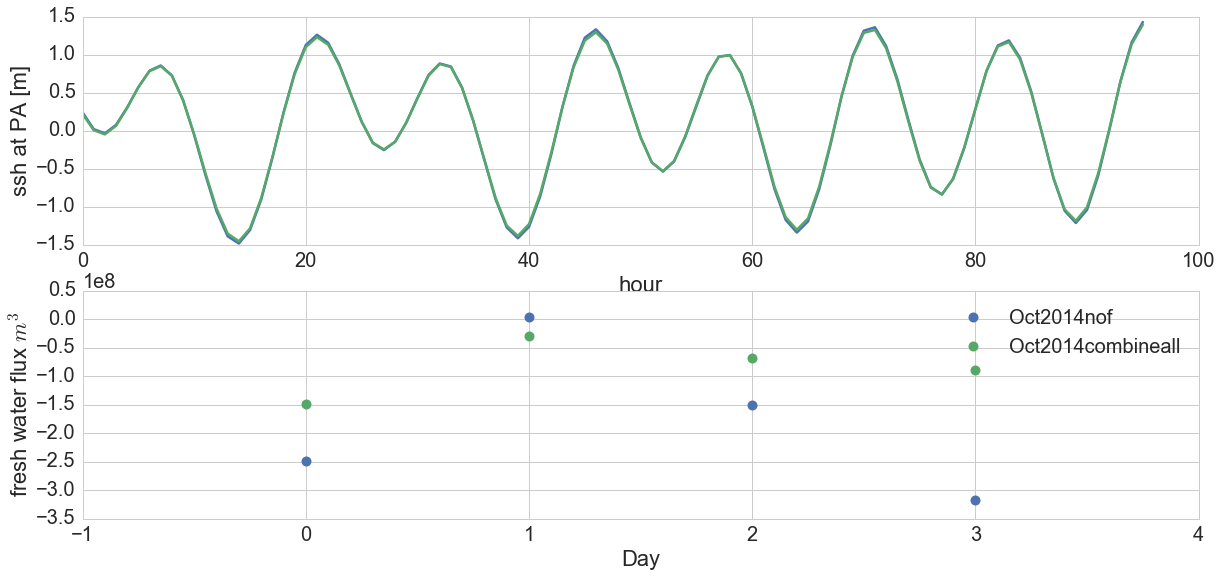

In [44]:
## weak wind october nof vs f
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':48,'Oct2014combineall':48}
ten = {'Oct2014nof':143,'Oct2014combineall':143}
inte_trans = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans['Oct2014combineall'].sum() - inte_trans['Oct2014nof'].sum())/(4*24*3600)

586.237026817068

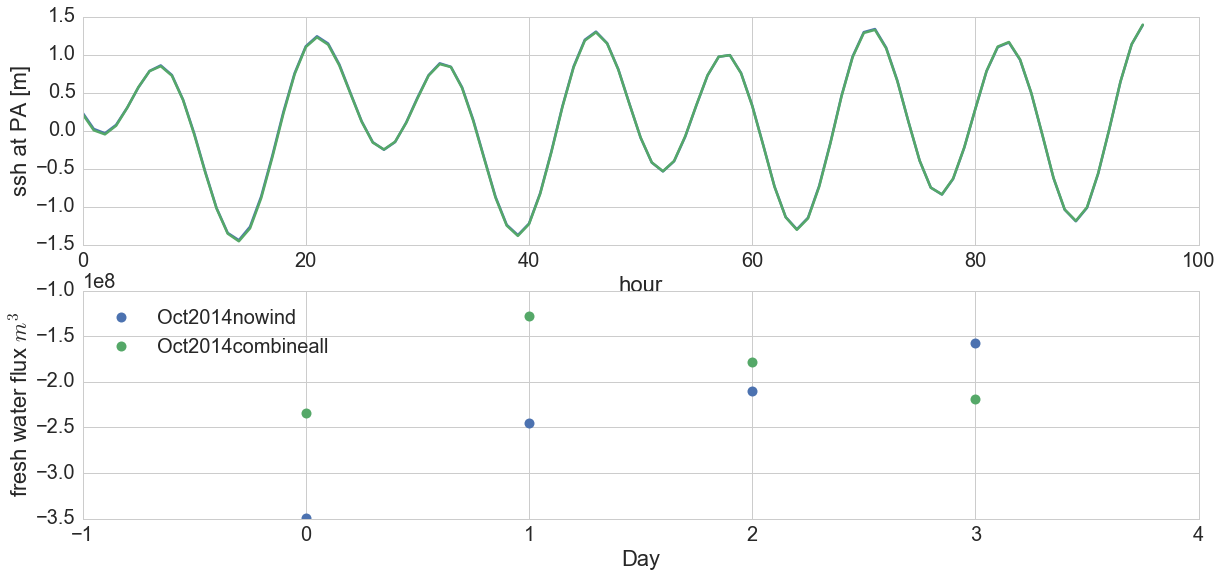

In [15]:
## weak wind nowind vs all
paths = ['Oct2014nowind','Oct2014combineall']
tst = {'Oct2014nowind':48,'Oct2014combineall':48}
ten = {'Oct2014nowind':143,'Oct2014combineall':143}
inte_trans_oct_weakwind = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_oct_weakwind['Oct2014combineall'].sum() - inte_trans_oct_weakwind['Oct2014nowind'].sum())/(24*4*3600)

-2815.5928425946331

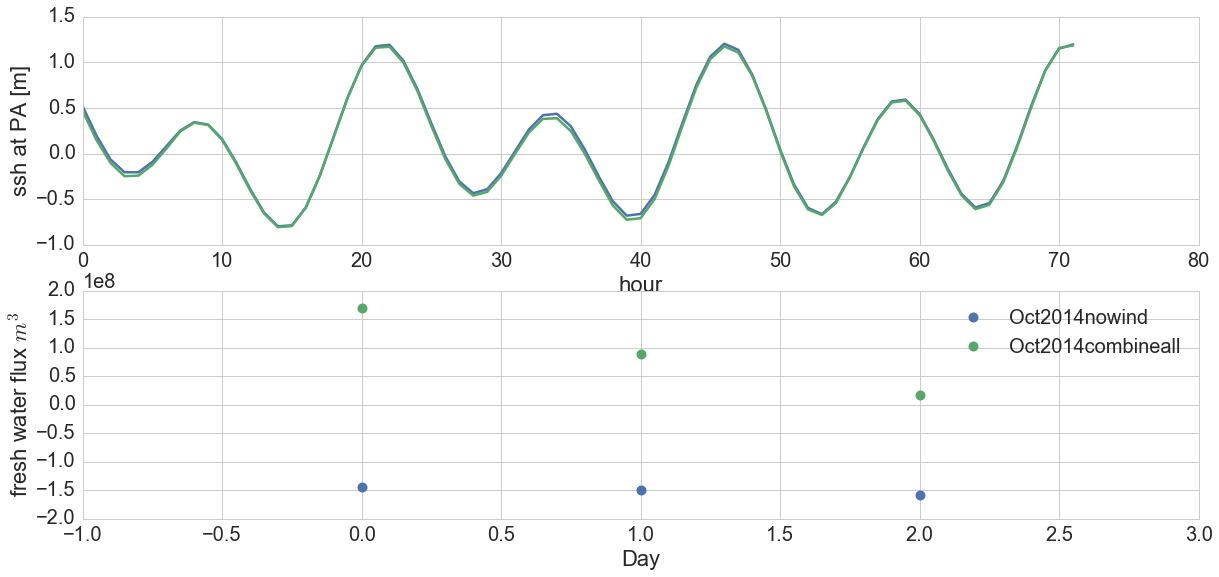

In [16]:
## moderate wind October
paths = ['Oct2014nowind','Oct2014combineall']
tst = {'Oct2014nowind':408,'Oct2014combineall':408}
ten = {'Oct2014nowind':479,'Oct2014combineall':479}
inte_trans=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans['Oct2014nowind'].sum() - inte_trans['Oct2014combineall'].sum())/(24*3*3600)

-580.29257117311988

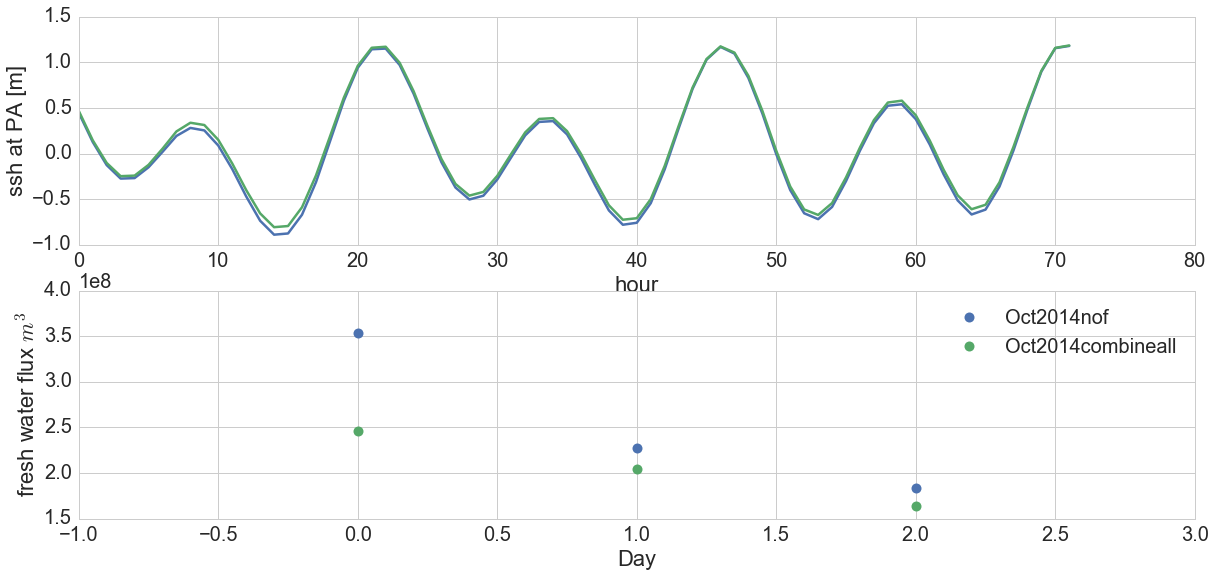

In [16]:
## moderate wind October f vs nof
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':408,'Oct2014combineall':408}
ten = {'Oct2014nof':479,'Oct2014combineall':479}
inte_transfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_transfnof['Oct2014combineall'].sum() - inte_transfnof['Oct2014nof'].sum())/(24*3*3600)

650.71536560133427

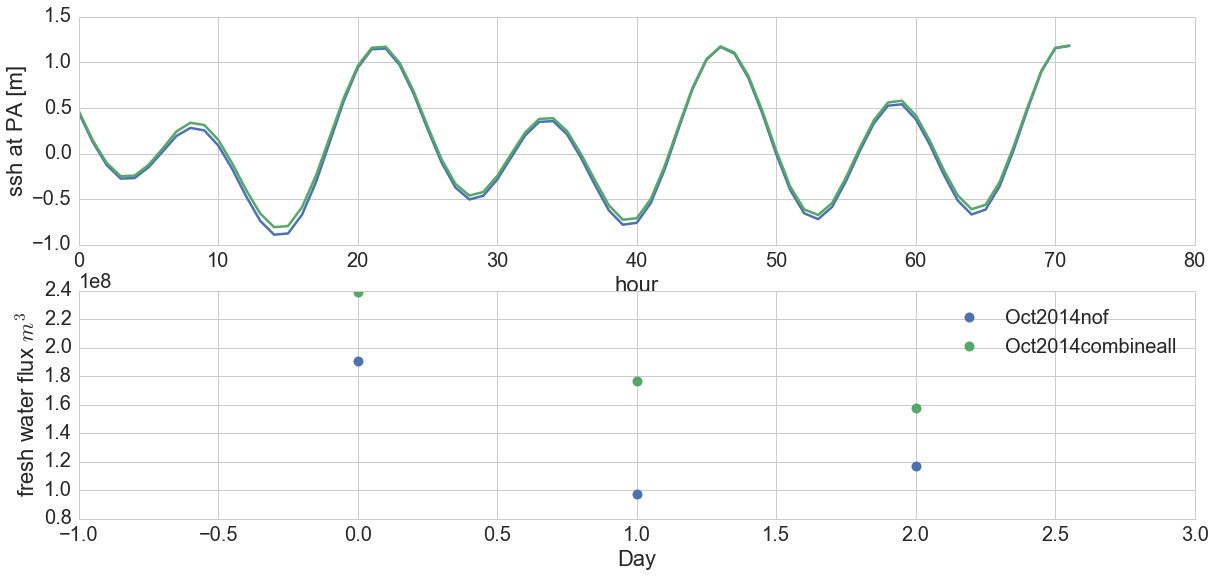

In [26]:
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':408,'Oct2014combineall':408}
ten = {'Oct2014nof':479,'Oct2014combineall':479}
inte_transfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_transfnof['Oct2014combineall'].sum() - inte_transfnof['Oct2014nof'].sum())/(24*3*3600)

4121.5810430586034

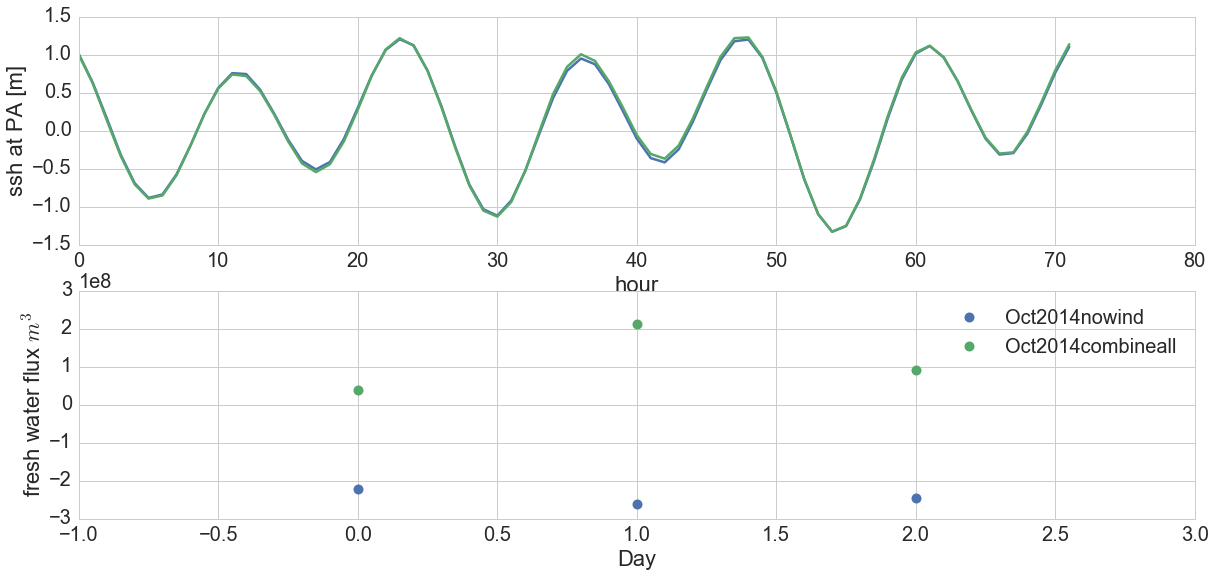

In [18]:
## strong wind October 
paths = ['Oct2014nowind','Oct2014combineall']
tst = {'Oct2014nowind':480,'Oct2014combineall':480}
ten = {'Oct2014nowind':551,'Oct2014combineall':551}
inte_trans_oct_strong_NW=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_oct_strong_NW['Oct2014combineall'].sum() - inte_trans_oct_strong_NW['Oct2014nowind'].sum())/(3*24*3600)

708157754.7646805

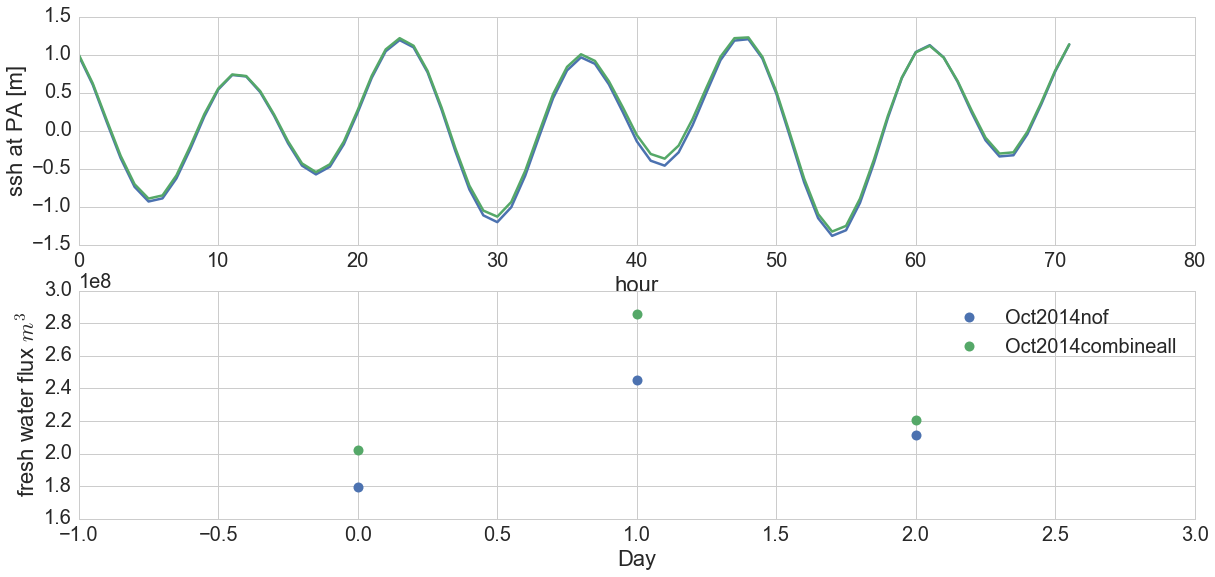

In [15]:
## strong wind October nof vs f
paths = ['Oct2014nof','Oct2014combineall']
tst = {'Oct2014nof':480,'Oct2014combineall':480}
ten = {'Oct2014nof':551,'Oct2014combineall':551}
inte_trans_oct_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
inte_trans_oct_strong_NWfnof['Oct2014combineall'].sum() - inte_trans_oct_strong_NWfnof['Oct2014nof'].sum()/(3*24*3600)

In [17]:
(inte_trans_oct_strong_NWfnof['Oct2014combineall'].sum() - inte_trans_oct_strong_NWfnof['Oct2014nof'].sum())/(3*24*3600)

278.46860910415143

{'Oct2014combineall': array([  2.11209454e+07,   1.90126894e+08,   7.45344099e+07]),
 'Oct2014nowind': array([ -2.22411455e+08,  -2.62833414e+08,  -2.39903149e+08])}

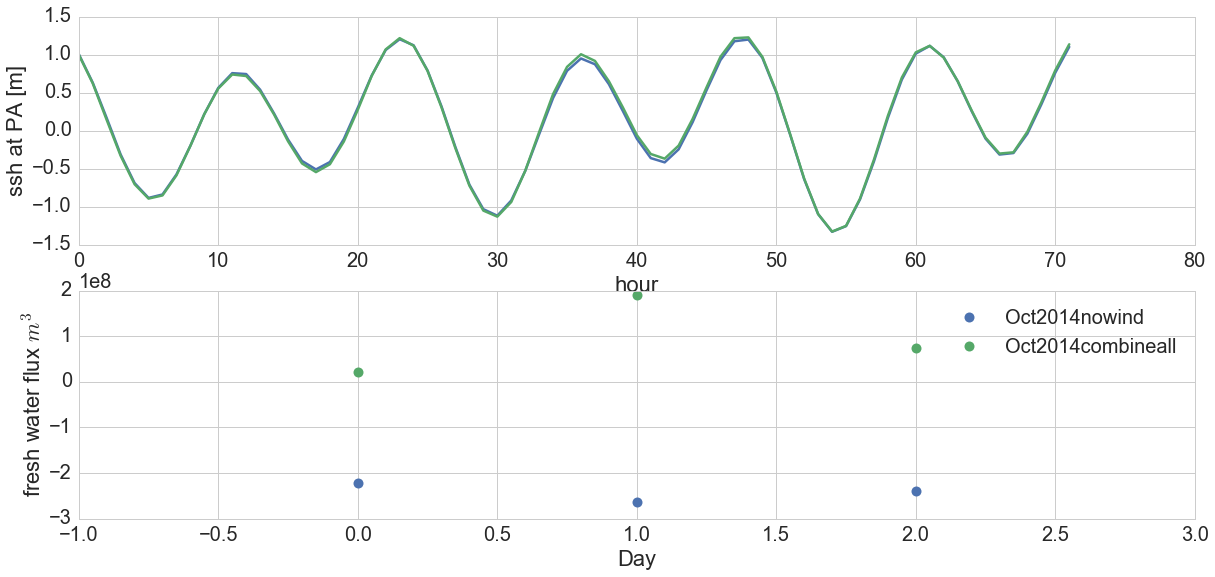

In [15]:
plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,-1,'1',tst,ten,paths,fresh_flag = 'fresh')

4573.0805544653986

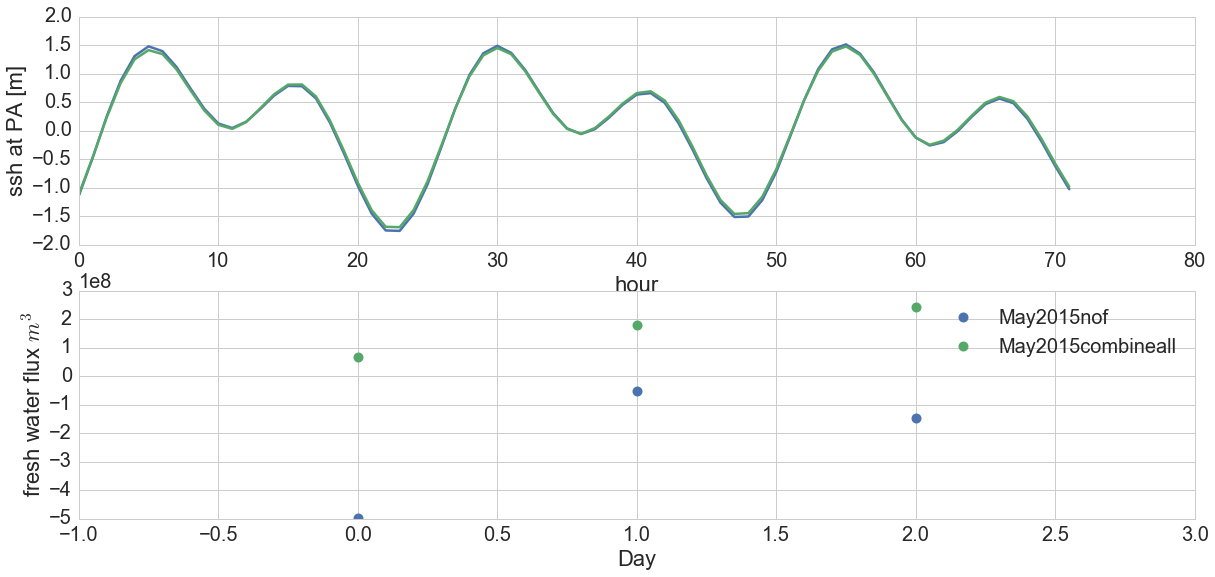

In [45]:
## weak wind May nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':192,'May2015combineall':192}
ten = {'May2015nof':263,'May2015combineall':263}
inte_weak_May = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_weak_May['May2015combineall'].sum() - inte_weak_May['May2015nof'].sum())/(3*24*3600)

4461.7221311127605

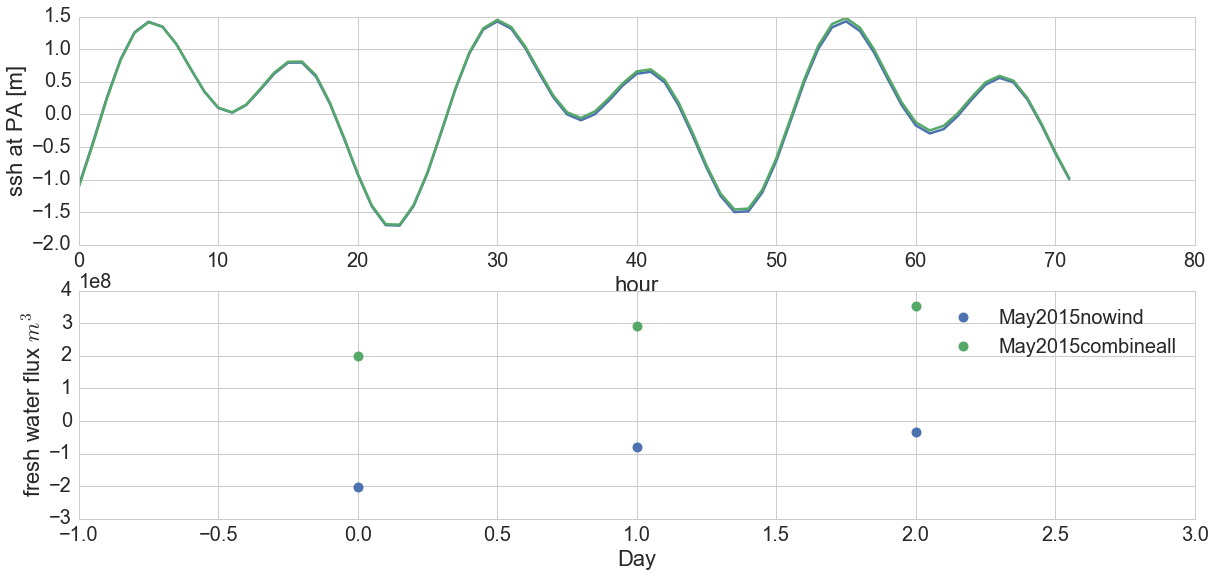

In [19]:
## weak wind May 
paths = ['May2015nowind','May2015combineall']
tst = {'May2015nowind':192,'May2015combineall':192}
ten = {'May2015nowind':263,'May2015combineall':263}
inte_weak_MayWind = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_weak_MayWind['May2015combineall'].sum() - inte_weak_MayWind['May2015nowind'].sum())/(3*24*3600)

In [50]:
(inte_weak_MayWind['May2015combineall'].sum() - inte_weak_MayWind['May2015nowind'].sum())/(3*24*3600)

4856.9329803594292

-7163.5826377781414

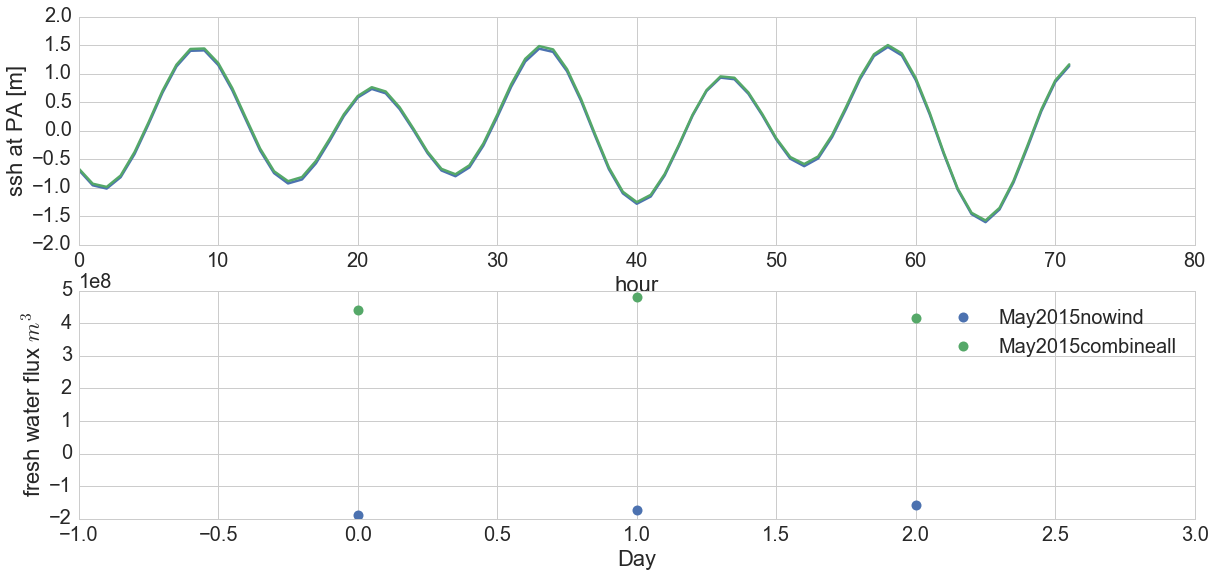

In [23]:
## moderate wind May NW
paths = ['May2015nowind','May2015combineall']
tst = {'May2015nowind':288,'May2015combineall':288}
ten = {'May2015nowind':359,'May2015combineall':359}
inte_may_NW = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_may_NW['May2015nowind'].sum() - inte_may_NW['May2015combineall'].sum())/(24*3*3600)

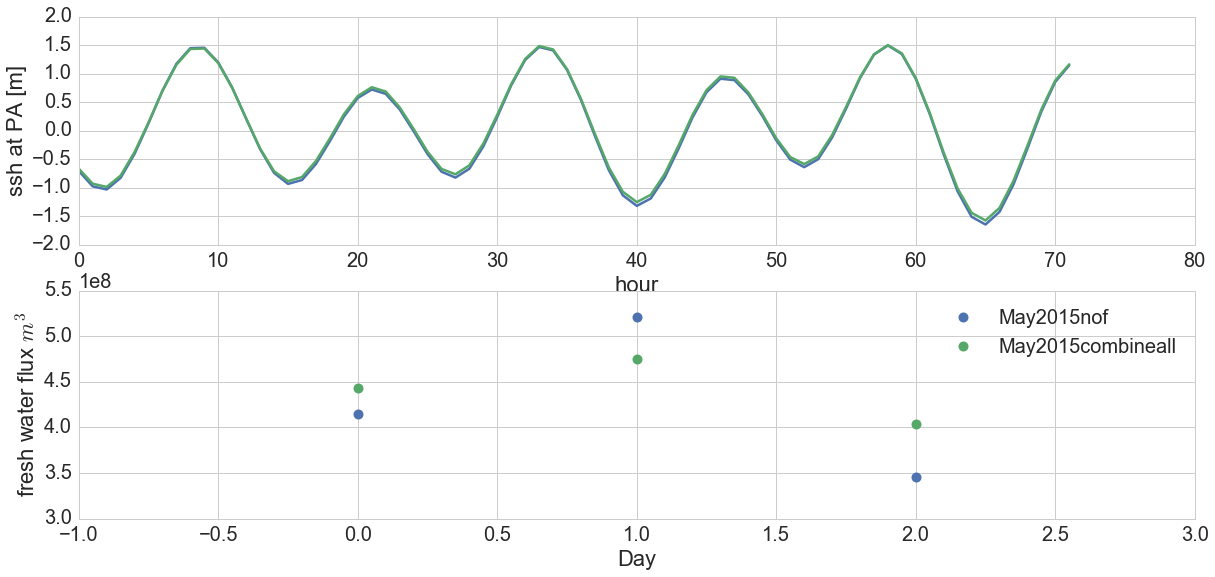

In [18]:
## moderate wind May NW nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':288,'May2015combineall':288}
ten = {'May2015nof':359,'May2015combineall':359}
inte_may_NW_fnof = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')

531.26307321346053

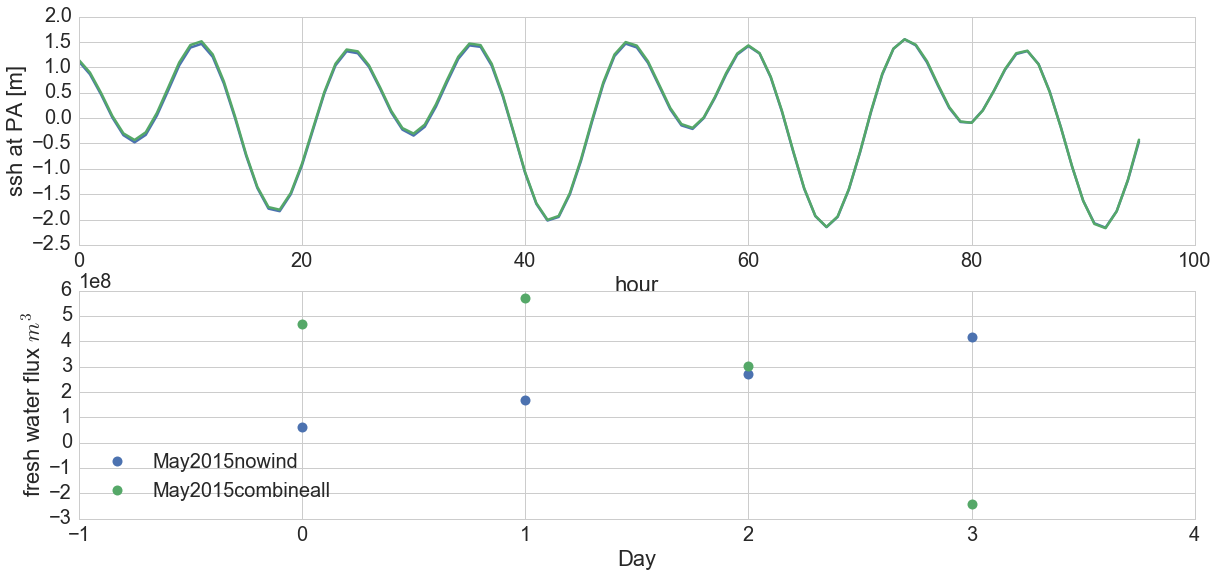

In [20]:
## moderate wind May SE
paths = ['May2015nowind','May2015combineall']
tst = {'May2015nowind':360,'May2015combineall':360}
ten = {'May2015nowind':455,'May2015combineall':455}
inte_may_SE = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_may_SE['May2015combineall'].sum() - inte_may_SE['May2015nowind'].sum())/(4*24*3600)

-7384.9328288962652

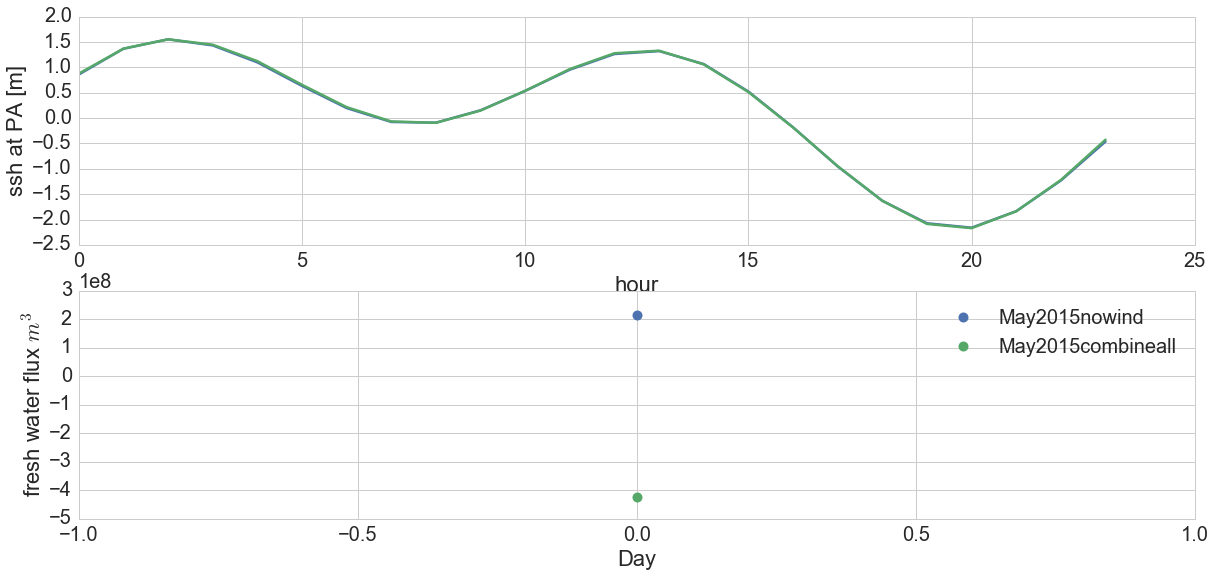

In [28]:
tst = {'May2015nowind':432,'May2015combineall':432}
ten = {'May2015nowind':455,'May2015combineall':455}
inte_may_SE = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_may_SE['May2015combineall'].sum() - inte_may_SE['May2015nowind'].sum())/(24*3600)

NameError: name 'inte_may_SEfnof' is not defined

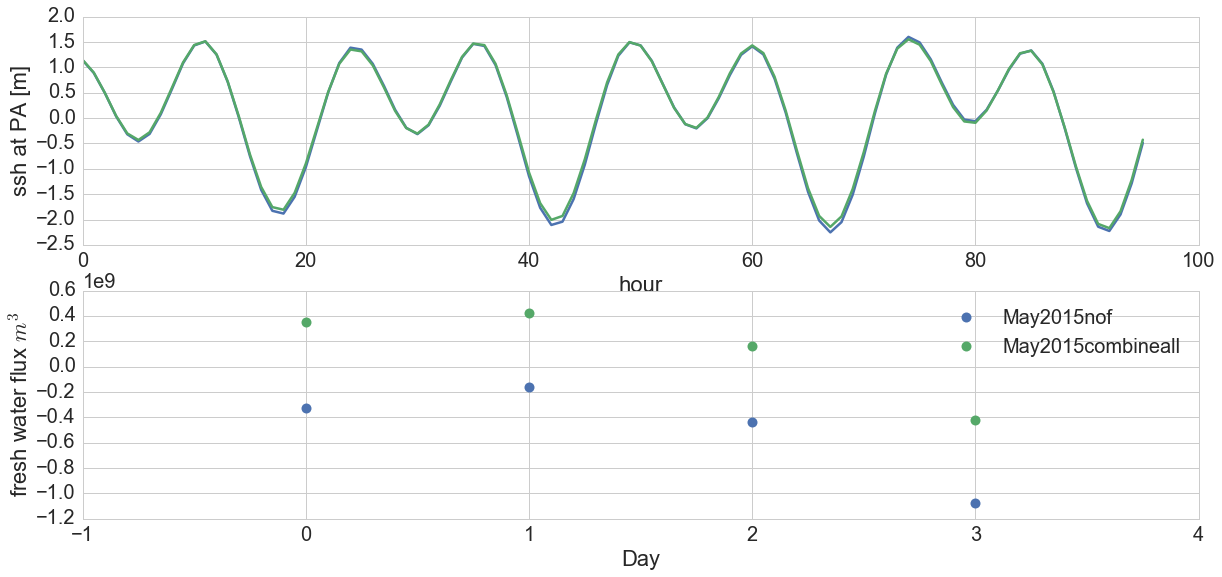

In [12]:
## moderate wind May SE nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':360,'May2015combineall':360}
ten = {'May2015nof':455,'May2015combineall':455}
inte_may_SE_fnof = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_may_SEfnof['May2015combineall'].sum() - inte_may_SEfnof['May2015nof'].sum())/(24*3600*4)

In [13]:
(inte_may_SE_fnof['May2015combineall'].sum() - inte_may_SE_fnof['May2015nof'].sum())/(24*3600*4)

7284.483429907511

-8320.0089290050091

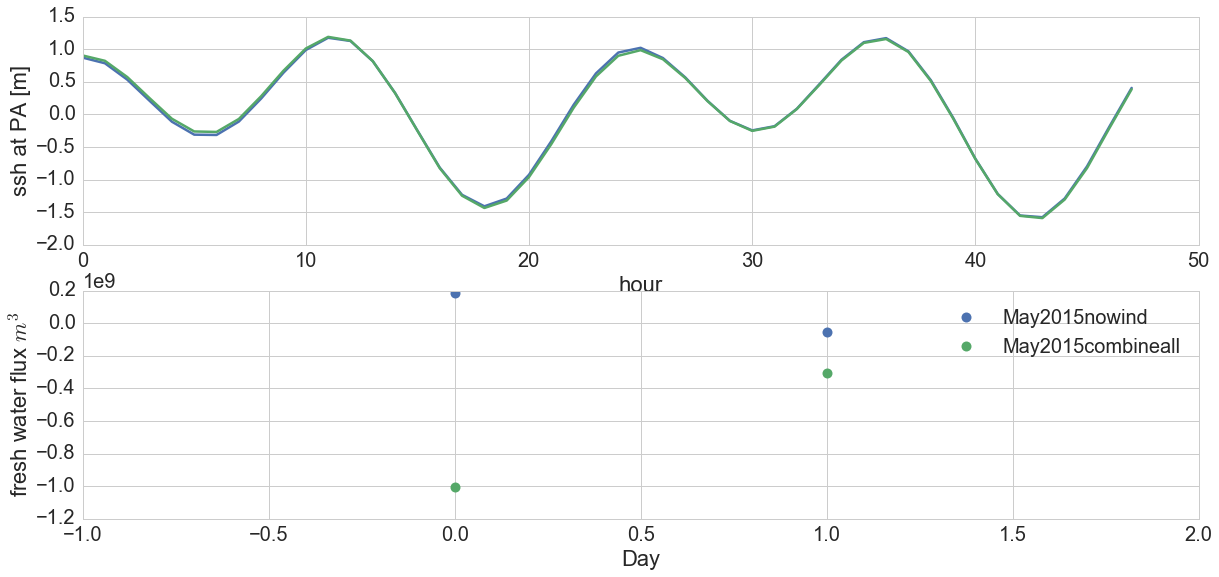

In [21]:
## strong wind May 
paths = ['May2015nowind','May2015combineall']
tst = {'May2015nowind':24,'May2015combineall':24}
ten = {'May2015nowind':71,'May2015combineall':71}
inte_trans_may_strong_SE=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_may_strong_SE['May2015combineall'].sum() - inte_trans_may_strong_SE['May2015nowind'].sum())/(2*24*3600)

7956.5438564584501

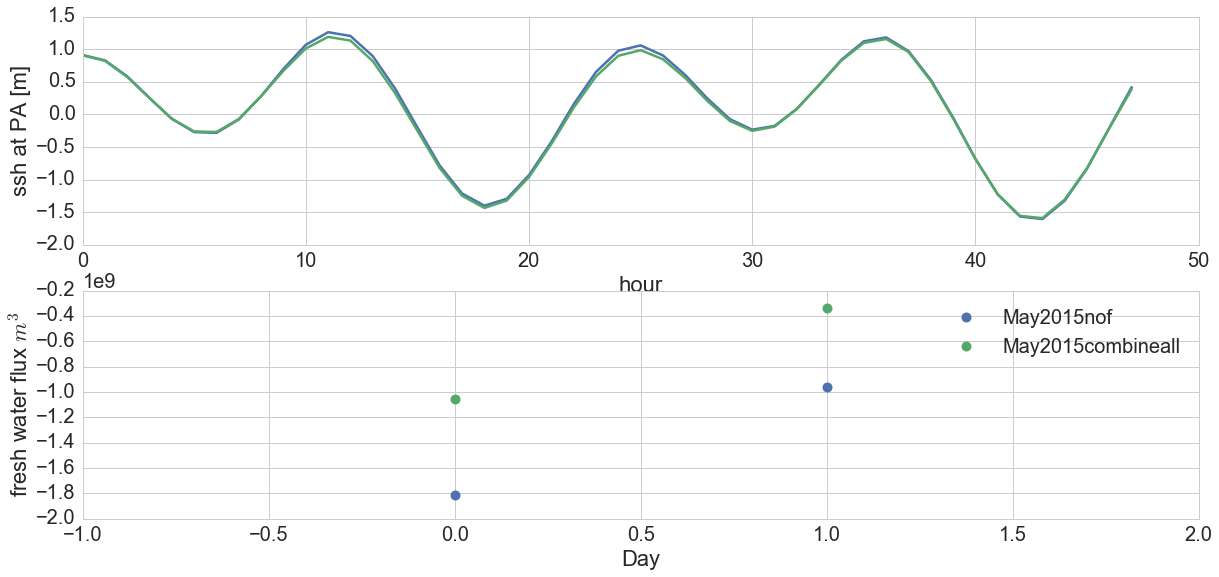

In [14]:
## strong May nof vs f
paths = ['May2015nof','May2015combineall']
tst = {'May2015nof':24,'May2015combineall':24}
ten = {'May2015nof':71,'May2015combineall':71}
inte_trans_may_strong_SEfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_may_strong_SEfnof['May2015combineall'].sum() - inte_trans_may_strong_SEfnof['May2015nof'].sum())/(2*24*3600)

2066.2324991202599

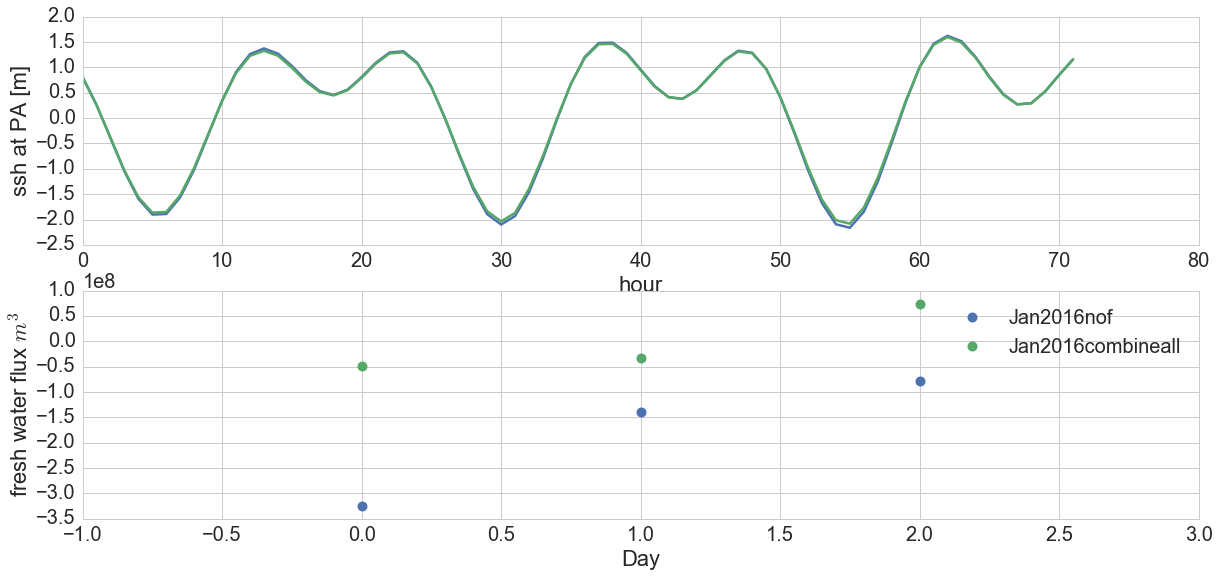

In [46]:
## weak wind Jan nof vs f
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':168,'Jan2016combineall':168}
ten = {'Jan2016nof':239,'Jan2016combineall':239}
jan_weak_f = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(jan_weak_f['Jan2016combineall'].sum() - jan_weak_f['Jan2016nof'].sum())/(3*24*3600)

210.79887135622522

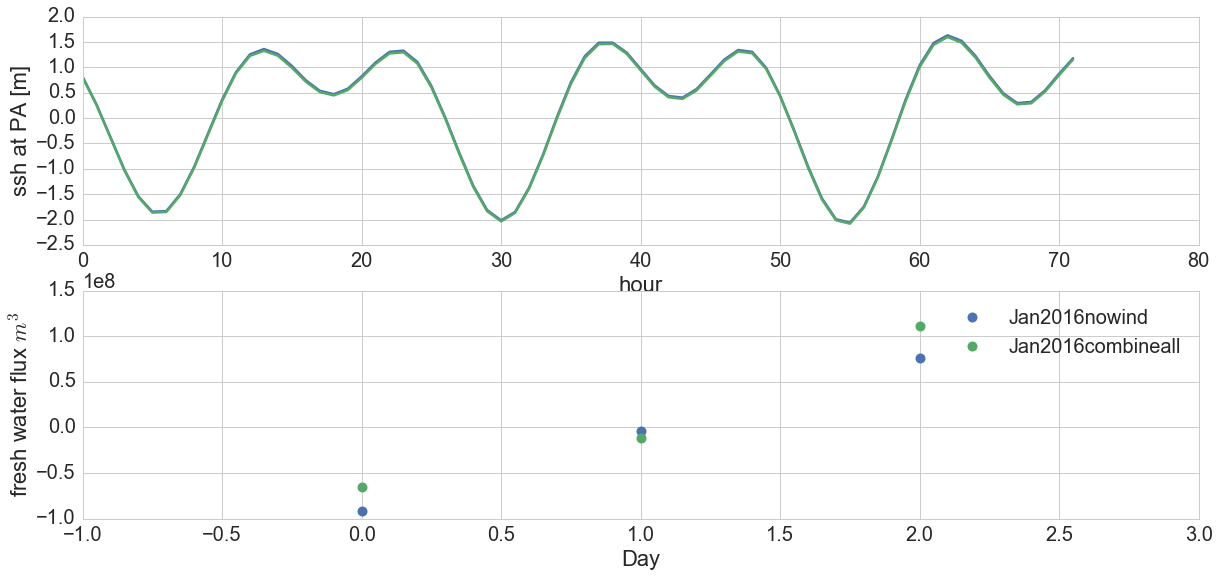

In [ ]:
## weak wind Jan 
paths = ['Jan2016nowind','Jan2016combineall']
tst = {'Jan2016nowind':168,'Jan2016combineall':168}
ten = {'Jan2016nowind':239,'Jan2016combineall':239}
jan_weak_wind = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(jan_weak_wind['Jan2016combineall'].sum() - jan_weak_wind['Jan2016nowind'].sum())/(3*24*3600)

In [ ]:
## moderate NW wind Jan 
paths = ['Jan2016nowind','Jan2016combineall']
tst = {'Jan2016nowind':384,'Jan2016combineall':384}
ten = {'Jan2016nowind':455,'Jan2016combineall':455}
inte_janNW = plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_janNW['Jan2016combineall'].sum() - inte_janNW['Jan2016nowind'].sum())/(24*3*3600)

-926.62597702351661

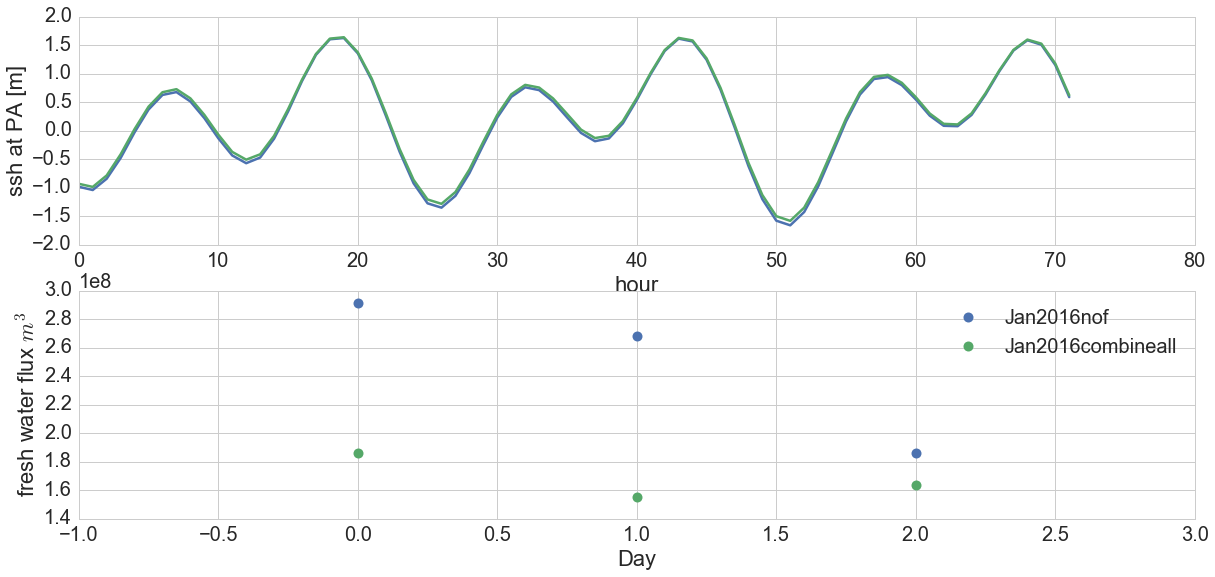

In [33]:
## moderate NW wind Jan nof vs f 
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':384,'Jan2016combineall':384}
ten = {'Jan2016nof':455,'Jan2016combineall':455}
inte_jan_NW_fnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_jan_NW_fnof['Jan2016combineall'].sum() - inte_jan_NW_fnof['Jan2016nof'].sum())/(24*3*3600)

-292.11908089544033

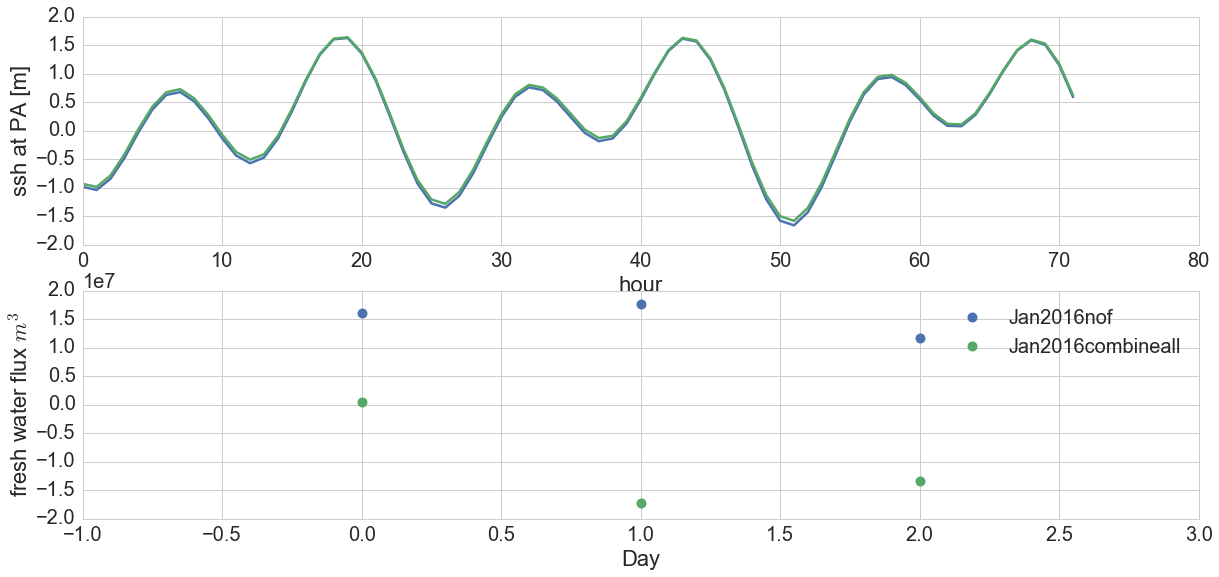

In [41]:
## moderate NW wind Jan nof vs f 
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':384,'Jan2016combineall':384}
ten = {'Jan2016nof':455,'Jan2016combineall':455}
inte_jan_NW_fnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_jan_NW_fnof['Jan2016combineall'].sum() - inte_jan_NW_fnof['Jan2016nof'].sum())/(24*3*3600)

53.514667075994531

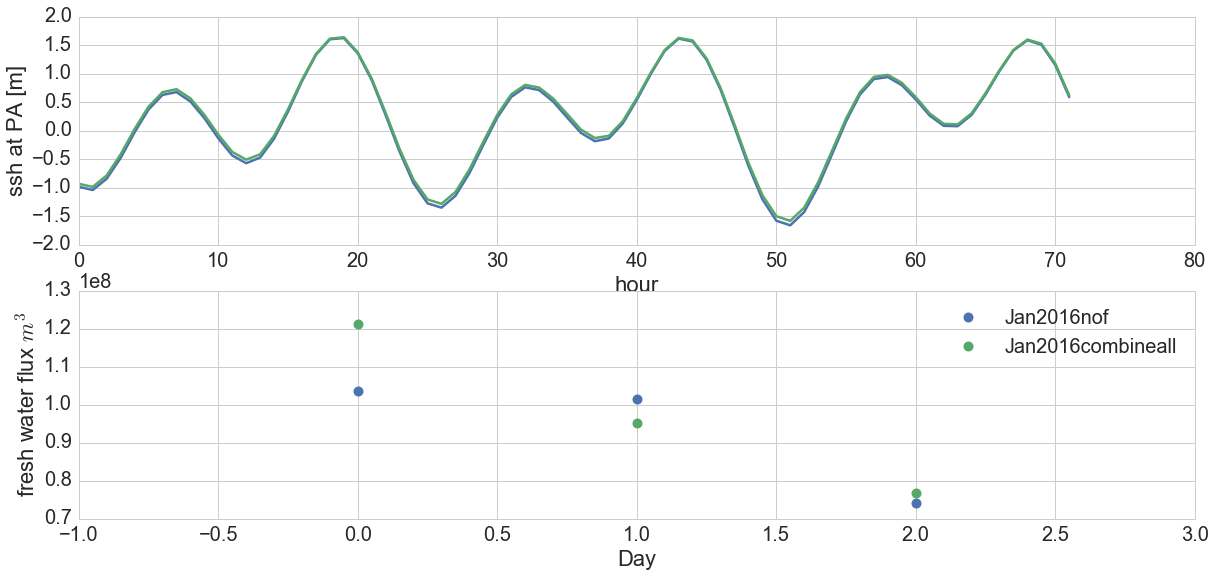

In [25]:
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':384,'Jan2016combineall':384}
ten = {'Jan2016nof':455,'Jan2016combineall':455}
inte_jan_NW_fnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_jan_NW_fnof['Jan2016combineall'].sum() - inte_jan_NW_fnof['Jan2016nof'].sum())/(24*3*3600)

In [ ]:
## strong wind Jan 
paths = ['Jan2016nowind','Jan2016combineall']
tst = {'Jan2016nowind':624,'Jan2016combineall':624}
ten = {'Jan2016nowind':671,'Jan2016combineall':671}
inte_trans_jan_strong_NW=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NW['Jan2016combineall'].sum() - inte_trans_jan_strong_NW['Jan2016nowind'].sum())/(2*24*3600)

In [ ]:
## strong wind Jan 
paths = ['Jan2016nowind','Jan2016combineall']
tst = {'Jan2016nowind':480,'Jan2016combineall':480}
ten = {'Jan2016nowind':503,'Jan2016combineall':503}
inte_trans_jan_strong_NW=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,39,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NW['Jan2016combineall'].sum() - inte_trans_jan_strong_NW['Jan2016nowind'].sum())/(2*24*3600)

-2034.3310259206821

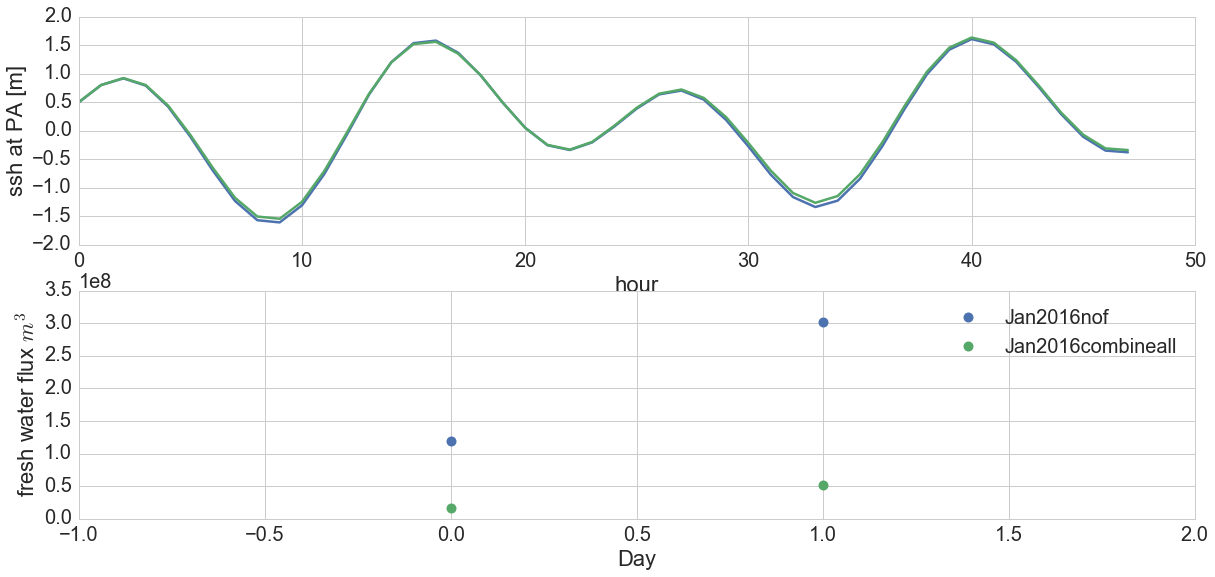

In [34]:
## strong wind Jan nof vs f
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':624,'Jan2016combineall':624}
ten = {'Jan2016nof':671,'Jan2016combineall':671}
inte_trans_jan_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NWfnof['Jan2016combineall'].sum() - inte_trans_jan_strong_NWfnof['Jan2016nof'].sum())/(2*24*3600)

In [31]:
inte_trans_jan_strong_NWfnof

{'Jan2016combineall': array([ 17229004.31048302,  51373011.95530569]),
 'Jan2016nof': array([  1.18721413e+08,   3.01413005e+08])}

65.091929732347594

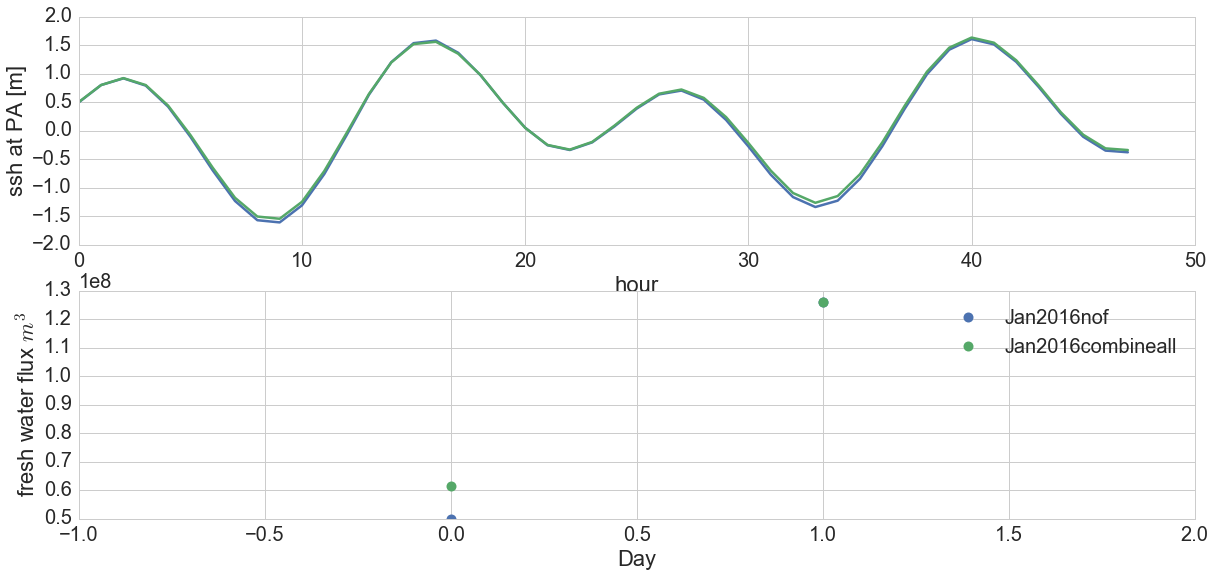

In [23]:
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':624,'Jan2016combineall':624}
ten = {'Jan2016nof':671,'Jan2016combineall':671}
inte_trans_jan_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NWfnof['Jan2016combineall'].sum() - inte_trans_jan_strong_NWfnof['Jan2016nof'].sum())/(2*24*3600)

943.57865848048129

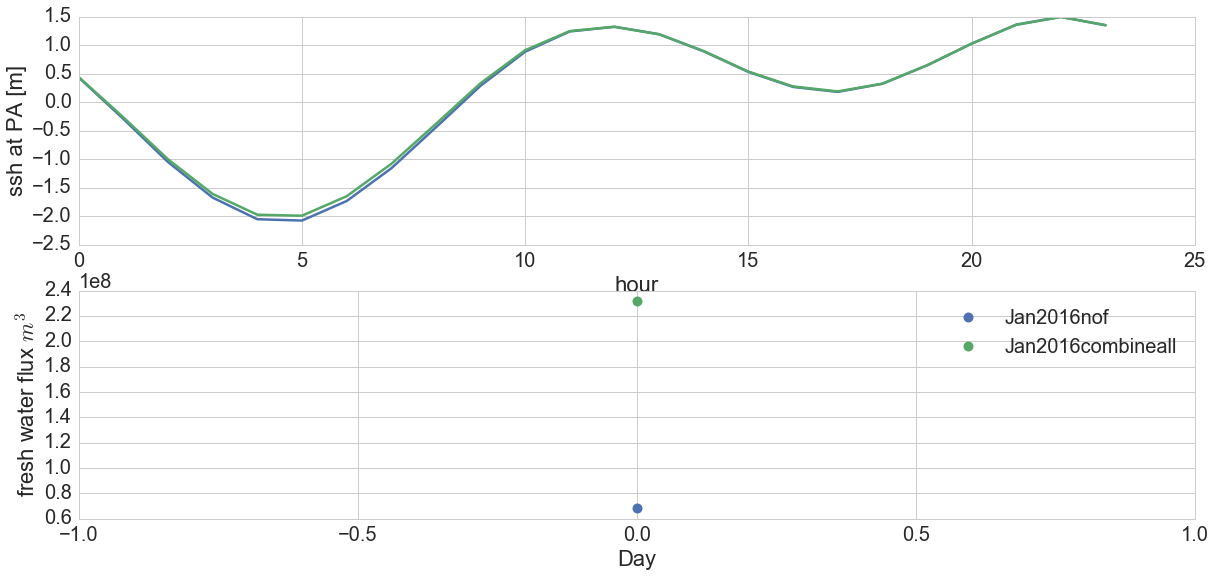

In [20]:
## strong wind Jan nof vs f
paths = ['Jan2016nof','Jan2016combineall']
tst = {'Jan2016nof':480,'Jan2016combineall':480}
ten = {'Jan2016nof':503,'Jan2016combineall':503}
inte_trans_jan_strong_NWfnof=plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = 'fresh')
(inte_trans_jan_strong_NWfnof['Jan2016combineall'].sum() - inte_trans_jan_strong_NWfnof['Jan2016nof'].sum())/(2*24*3600)

{'Jan2016OnlyRiver': array([-87987780.46355024, -87765799.3209123 , -74078935.48017921,
        -76360430.52946998]),
 'May2015OnlyRiver': array([ -2.58210833e+08,  -2.49970857e+08,  -2.52817866e+08,
         -2.56477046e+08]),
 'Oct2014OnlyRiver': array([ -1.55004638e+08,  -1.33251250e+08,  -1.18816297e+08,
         -1.15851475e+08])}

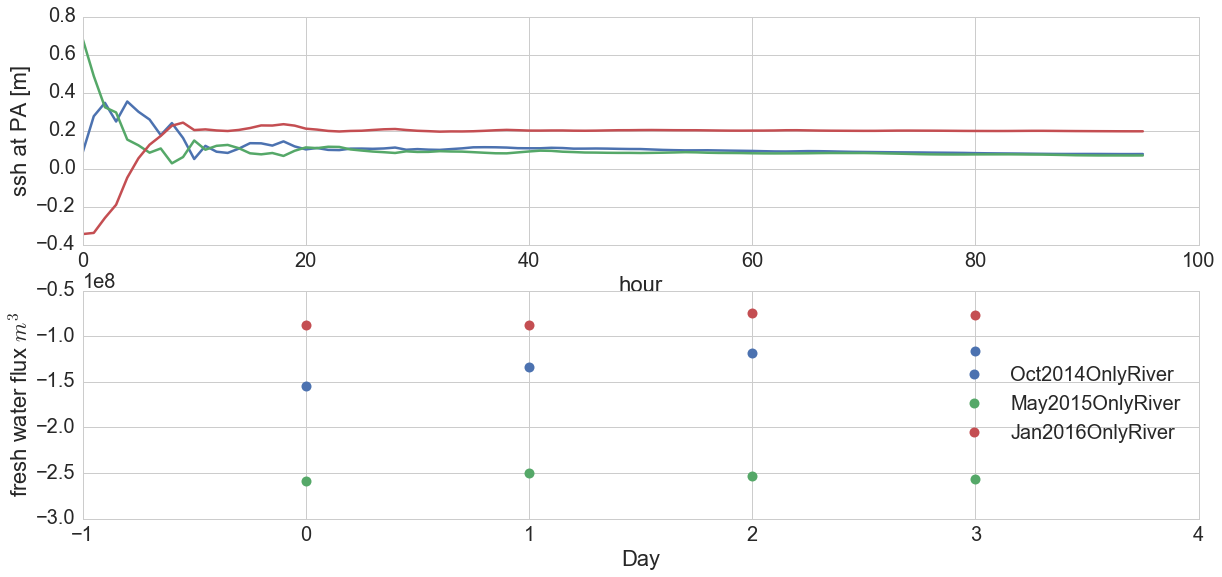

In [26]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':95,'May2015OnlyRiver':95,'Jan2016OnlyRiver':95}
plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,-1,'4',tst,ten,paths,fresh_flag = 'fresh')

In [9]:
def along_cross_depth(S,U,V,ssh,lon,lat,depT,tran,tst,ten,paths,fresh_flag = True):
    """Quantify cross/along-shore fresh water/total volume transport 
    over a period of time at different depths"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                   paths,fresh_flag = fresh_flag)
    fig, axs = plt.subplots(3,1,figsize = (12,12))
    if tran =='3' or tran =='4' or tran =='5':
        js = np.arange(transects[tran]['jen']-transects[tran]['jst'])
    else:
        js = np.arange(transects[tran]['ien']-transects[tran]['ist'])
    
    for pa,ax in zip(paths, [axs[0],axs[1],axs[2]]):
        transport = np.nansum(trans[pa][tst[pa]:ten[pa]+1],axis=0)
        mesh = ax.pcolormesh(js,depT, np.nansum(trans[pa],axis= 0),cmap = 'jet')
        cbar=fig.colorbar(mesh,ax =ax)
        ax.set_ylim([depT[-10],depT[0]])
        ax.set_title(pa)
    return transport

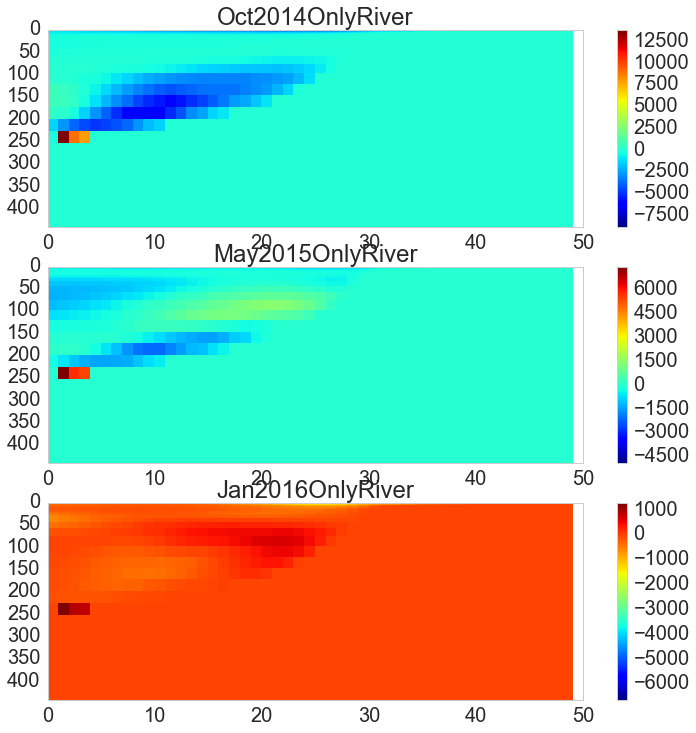

In [14]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
tranport = along_cross_depth(S,U,V,ssh,lon,lat,depT,'2',tst,ten,paths,fresh_flag = True)

In [30]:
def plot_series_transport(S,U,V,ssh,lon,lat,depT,dep,tran,tst,ten,paths,fresh_flag = True,y1lim = 4000):
    """This function was made to plot the fresh water transport/total water transport over 
    selected depth over a period of time for a specific run case over different river flows conditions"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depT,tran,tst,ten,\
                                                                   paths,fresh_flag = fresh_flag)
    fig, axs = plt.subplots(2,1,figsize = (12,10))
    ax= axs[0]
    for pa in paths:
        ax.plot(ssh[pa][tst[pa]:ten[pa]+1,86,89],label = pa)
    ax.set_ylabel('ssh at PA [m]')
    ax = axs[1]
    for pa in paths:
        trans_dep = np.nansum(np.nansum(trans[pa][tst[pa]:ten[pa]+1,depT[0]:depT[dep]+1],axis = 1),axis = 1)
        ax.plot(trans_dep,'-^',label = pa)
        ax.legend(loc = 'best')
        if fresh_flag == True:
            ax.set_ylabel('top ' + str(depT[dep])+' m fresh water flux $m^{3}s^{-1}$')
        else:
            ax.set_ylabel('top ' + str(depT[dep])+' m total volume flux $m^{3}s^{-1}$')
    ax.set_ylim([-y1lim,y1lim])
    ax.set_xlabel('time [hr]')

* only river

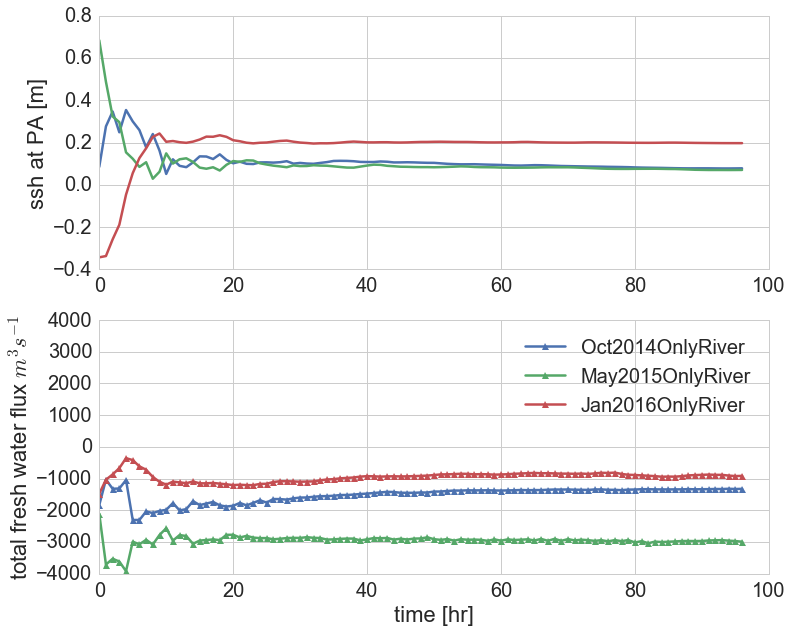

In [30]:
paths = ['Oct2014OnlyRiver','May2015OnlyRiver','Jan2016OnlyRiver']
tst = {'Oct2014OnlyRiver':0,'May2015OnlyRiver':0,'Jan2016OnlyRiver':0}
ten = {'Oct2014OnlyRiver':96,'May2015OnlyRiver':96,'Jan2016OnlyRiver':96}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'4',tst,ten,paths,fresh_flag = True)

* No wind

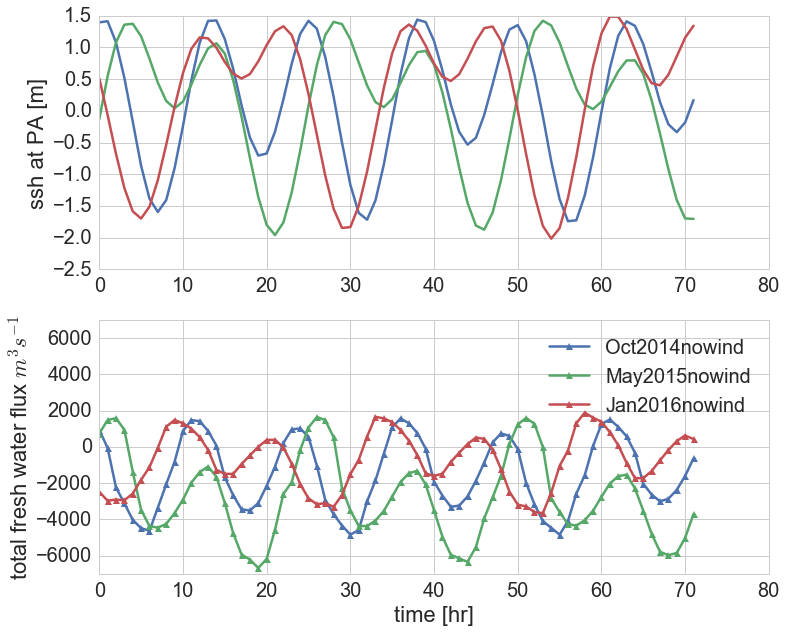

In [14]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind'] ## oct 9~11,may 7~9,jan 7~9 spring 
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'4',tst,ten,paths,fresh_flag = True,y1lim=7000)

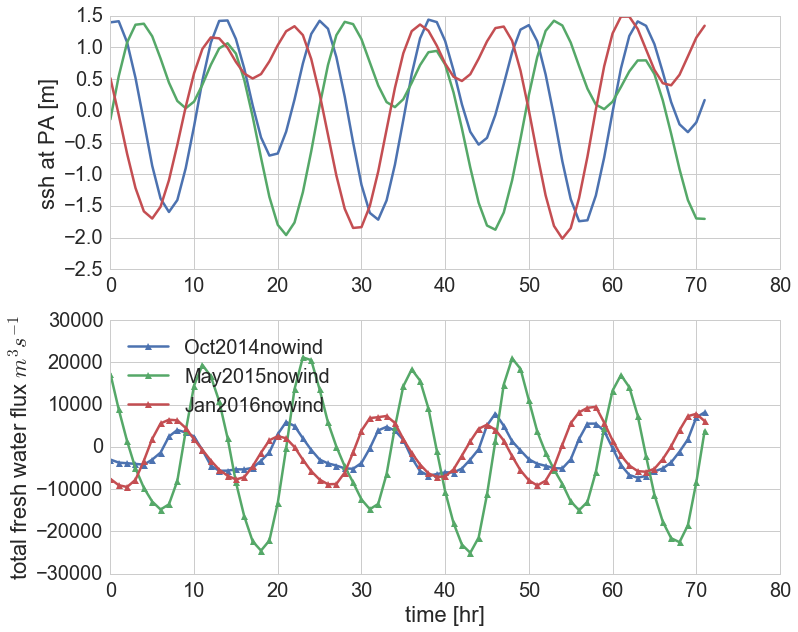

In [15]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind'] ## oct 9~11,may 7~9,jan 7~9 spring 
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'1',tst,ten,paths,fresh_flag = True,y1lim=3e4)

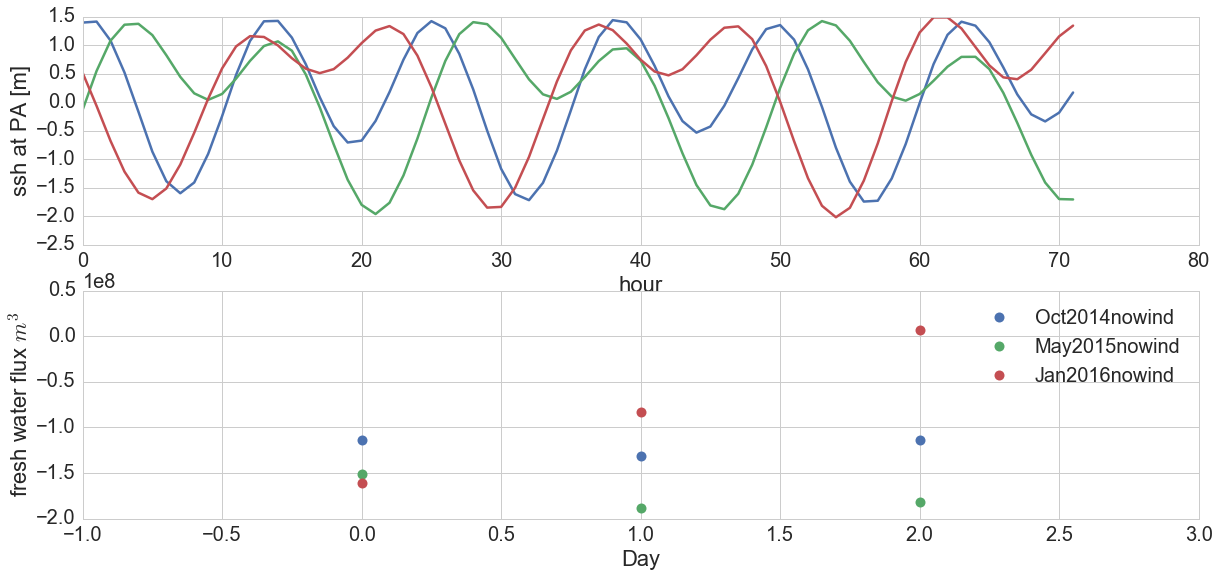

In [89]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind']
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,-1,'1',tst,ten,paths,fresh_flag = 'fresh')

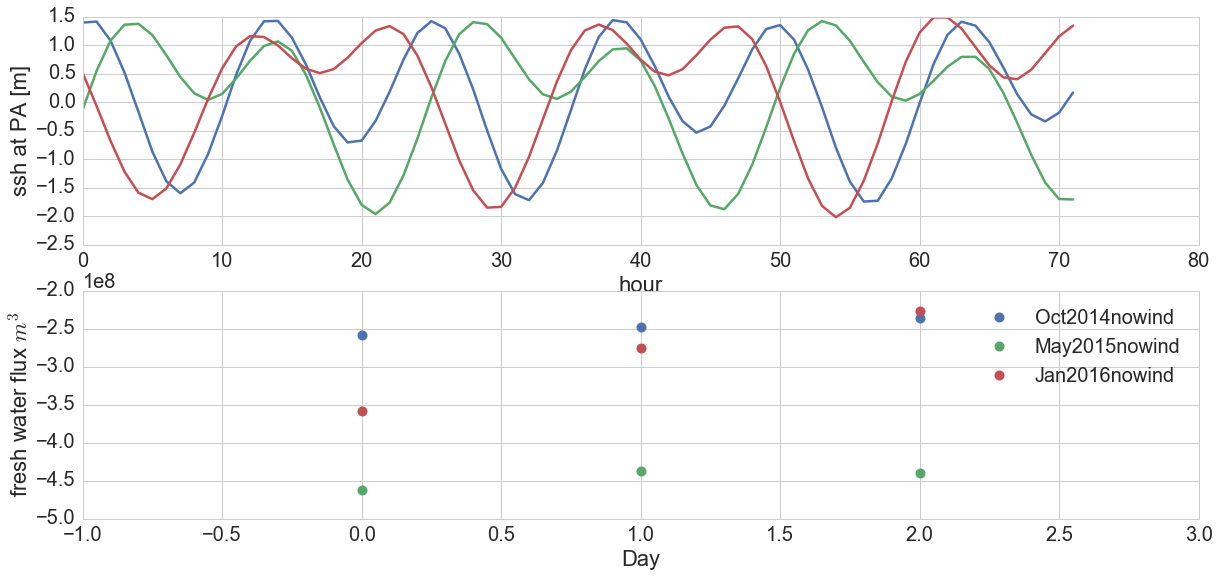

In [92]:
paths = ['Oct2014nowind','May2015nowind','Jan2016nowind']
tst = {'Oct2014nowind':192,'May2015nowind':144,'Jan2016nowind':144}
ten = {'Oct2014nowind':263,'May2015nowind':215,'Jan2016nowind':215}
plot_series_transportDaily(S,U,V,ssh,lon,lat,depT,10,'2',tst,ten,paths,fresh_flag = 'fresh')

* combine all

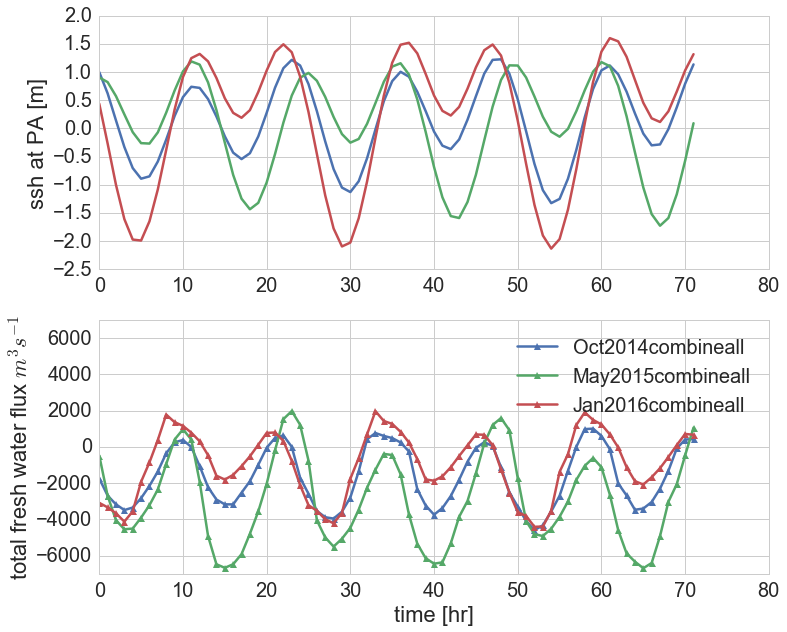

In [17]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480} ## total depths
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'4',tst,ten,paths,fresh_flag = True,y1lim=7000)

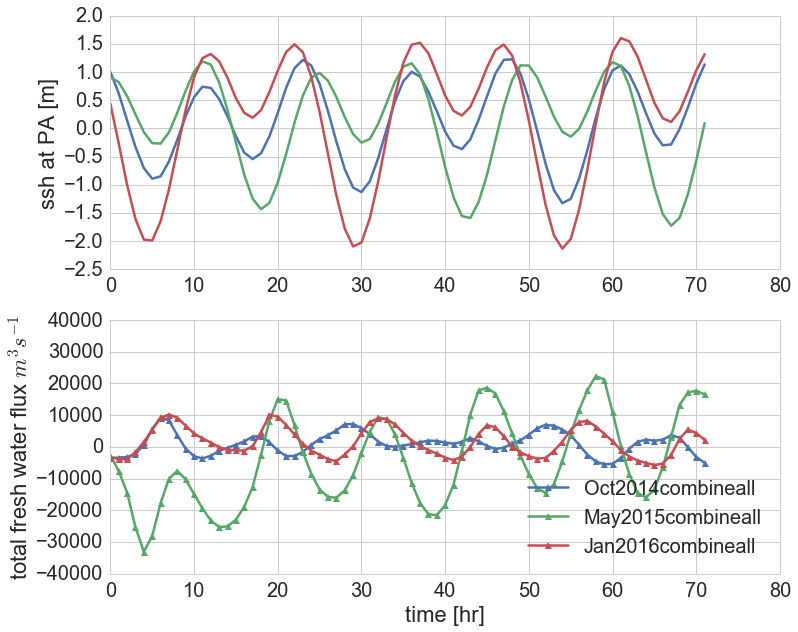

In [24]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480} ## total depths
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'1',tst,ten,paths,fresh_flag = True,y1lim=4e4)

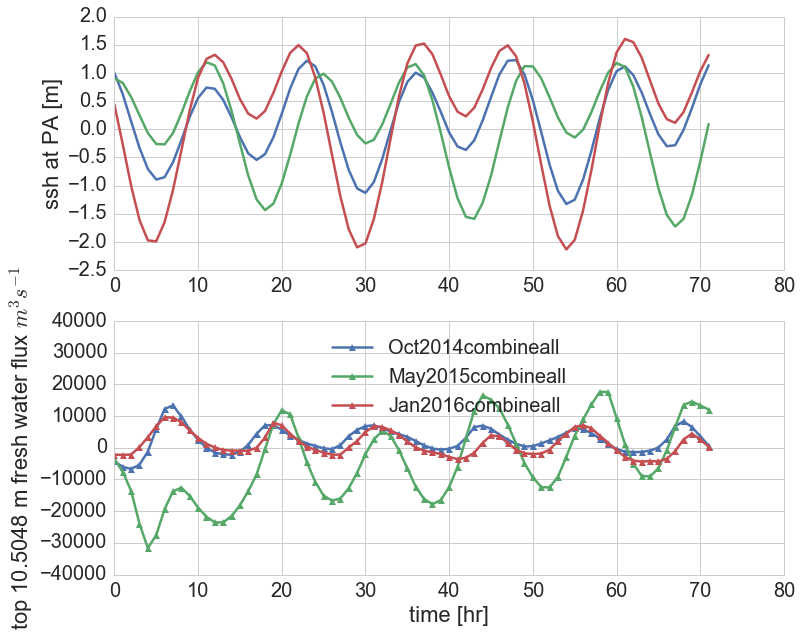

In [33]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480} ## top 10 m depths
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depT,10,'1',tst,ten,paths,fresh_flag = True,y1lim=4e4)

* Not much fresh water difference between top 10 m and total depths for 1. All go south.

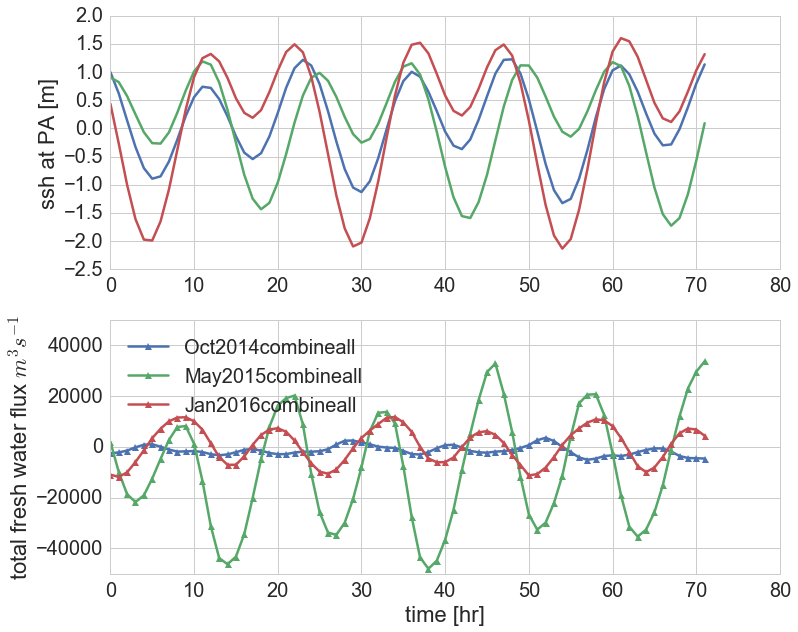

In [27]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480}## total depths
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depT,-1,'2',tst,ten,paths,fresh_flag = True,y1lim=5e4)

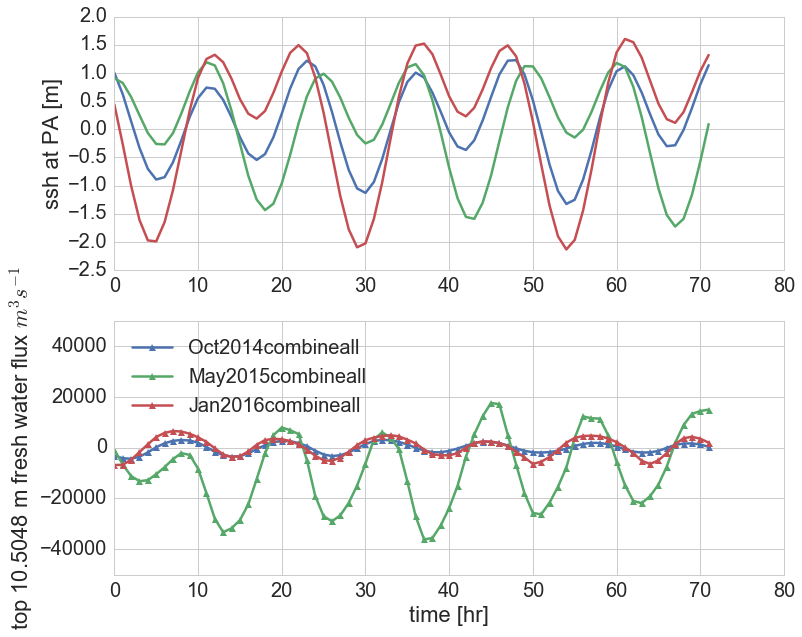

In [31]:
paths = ['Oct2014combineall','May2015combineall','Jan2016combineall'] ## oct 21~23,may 2~4,jan 21~23 strong winds 
tst = {'Oct2014combineall':480,'May2015combineall':24,'Jan2016combineall':480} ## top 10 m 
ten = {'Oct2014combineall':551,'May2015combineall':95,'Jan2016combineall':551}
plot_series_transport(S,U,V,ssh,lon,lat,depT,10,'2',tst,ten,paths,fresh_flag = True,y1lim=5e4)

* Almost twice magnitude of fresh water transported across 2 than 1. In May, integral over top 10 m, net fresh water direction along 2 is south while total depth is approx north. 